# Laboratorio 1 Fundamentos de Aprendizaje Profundo

Nombre: Antonina Arriagada

### 1. Definiciones e importación librerias

In [1]:
import torch
import torch.nn as nn
import time
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import seaborn as sns
from beepy import beep

In [2]:
def set_seed(seed=43):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(43)

#### 1.1 Definición de la red

In [4]:
class SimpleFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1):
        super(SimpleFFNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

#### 1.2 Definición de dataset y preprocesamiento de datos

##### 1.2.1 RandomDataset

In [5]:
class RandomDataSet(Dataset):
    def __init__(self, N, f):
        R_N_f = torch.rand(N, f)
        self.X = torch.bernoulli(R_N_f)
        R_N_1 = torch.rand(N, 1)
        self.Y = torch.bernoulli(R_N_1)
        self.num_features = f

    def __len__(self):
        return self.X.size()[0]

    def __getitem__(self, i):
        return self.X[i], self.Y[i]


##### 1.2.2 Dataset de clasificación binaria

In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [159]:
weather_data = pd.read_csv("dataset/weather.csv")
weather_data.describe()


Unnamed: 0       MinTemp       MaxTemp      Rainfall  Evaporation  \
count  25000.000000  24669.000000  24824.000000  24721.000000  9432.000000   
mean   12499.500000     13.294568     23.990558      2.674467     5.825138   
std     7217.022701      5.848304      6.114348      9.720306     4.871567   
min        0.000000     -3.300000      6.800000      0.000000     0.000000   
25%     6249.750000      8.900000     19.500000      0.000000     3.000000   
50%    12499.500000     14.000000     23.400000      0.000000     4.800000   
75%    18749.250000     17.900000     27.700000      0.600000     7.200000   
max    24999.000000     29.700000     47.300000    371.000000    86.200000   

          Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am  \
count  6664.000000   21545.000000  24428.000000  23770.000000  24609.000000   
mean      7.811945      37.772755     12.686917     16.837106     69.822951   
std       3.718698      13.212331      9.136115      9.095719     17.755908   
min       0.000000       7.000000      0.000000      0.000000      3.000000   
25%       5.500000      28.000000      6.000000      9.000000     58.000000   
50%       8.900000      35.000000     11.000000     17.000000     71.000000   
75%      10.600000      46.000000     19.000000     22.000000     83.000000   
max      14.000000     135.000000    130.000000     83.000000    100.000000   

        Humidity3pm   Pressure9am   Pressure3pm      Cloud9am      Cloud3pm  \
count  23936.000000  20172.000000  20173.000000  14136.000000  13815.000000   
mean      52.762826   1018.173290   1015.627438      4.251556      4.409265   
std       21.210121      6.481112      6.394829      2.968785      2.719235   
min        1.000000    980.500000    979.000000      0.000000      0.000000   
25%       37.000000   1013.800000   1011.300000      1.000000      2.000000   
50%       54.000000   1018.200000   1015.700000      5.000000      5.000000   
75%       68.000000   1022.600000   1020.000000      7.000000      7.000000   
max      100.000000   1039.900000   1036.800000      8.000000      8.000000   

            Temp9am       Temp3pm       RISK_MM  
count  24755.000000  24082.000000  25000.000000  
mean      17.953084     22.507171      2.677376  
std        5.394685      5.954540      9.705604  
min        0.300000      6.400000      0.000000  
25%       14.200000     18.100000      0.000000  
50%       18.400000     21.900000      0.000000  
75%       21.900000     26.100000      0.800000  
max       37.700000     46.700000    371.000000

In [160]:
print(weather_data.columns)


Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')


In [161]:
print(weather_data.sample(5))

       Unnamed: 0        Date      Location  MinTemp  MaxTemp  Rainfall  \
14892       14892  2009-05-08     Newcastle     11.5     17.6       1.2   
17998       17998  2009-11-21     NorahHead     21.0     26.6       NaN   
16751       16751  2014-10-29     Newcastle     15.0     25.0       0.0   
7575         7575  2013-09-28         Cobar     12.1     25.7       0.0   
9076         9076  2009-05-31  CoffsHarbour     13.2     18.6       3.4   

       Evaporation  Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm  \
14892          NaN       NaN         NaN            NaN  ...        91.0   
17998          NaN       NaN           S           54.0  ...        76.0   
16751          NaN       NaN         NaN            NaN  ...        50.0   
7575           NaN       NaN          SW           35.0  ...        10.0   
9076           3.4       2.8         ESE           39.0  ...        58.0   

      Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
14892         NaN   

In [162]:
weather_data.drop(columns=['Unnamed: 0', 'Date'], inplace=True)

In [163]:
print(weather_data.columns)


Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')


In [164]:
numeric_columns = weather_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = weather_data.select_dtypes(include=['object']).columns
weather_data[numeric_columns] = weather_data[numeric_columns].fillna(weather_data[numeric_columns].median())
weather_data[categorical_columns] = weather_data[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

In [165]:
print(weather_data.sample(5))

            Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
12076          Moree      7.3     13.2       5.0          1.6       1.2   
15132      Newcastle     19.6     22.2      22.0          4.8       8.9   
23715        Penrith     13.1     29.1       0.0          4.8       8.9   
19534      NorahHead     12.9     19.6       0.0          4.8       8.9   
5472   BadgerysCreek     19.0     29.3       0.0          4.8       8.9   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
12076          SW           50.0        WSW        SSW  ...         77.0   
15132         NNE           35.0         SE         SE  ...         89.0   
23715         WSW           54.0         SE        WNW  ...         26.0   
19534         NNE           30.0        WNW        NNE  ...         67.0   
5472          ESE           33.0         SE        ESE  ...         53.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
12076       1015.3 

In [ ]:
weather_data['RainTomorrow'] = weather_data['RainTomorrow'].fillna('No').apply(lambda x: 1 if x == 'Yes' else 0)


In [168]:
print(weather_data.sample(2))

            Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
21207  NorfolkIsland     15.5     20.2      71.6          4.8       7.9   
2695          Albury      1.8     17.2       0.0          4.8       8.9   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
21207         NNW           67.0        WNW         NW  ...         64.0   
2695            N           43.0          E        NNE  ...         60.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
21207       1009.5       1010.2       8.0       1.0     16.2     19.9   
2695        1022.0       1015.9       1.0       4.0      7.8     16.3   

       RainToday  RISK_MM  RainTomorrow  
21207        Yes      1.6             1  
2695          No      2.6             1  

[2 rows x 23 columns]


In [ ]:
weather_data = pd.get_dummies(weather_data, columns=categorical_columns, drop_first=True)


In [170]:
print(weather_data.columns)


Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RISK_MM', 'Location_BadgerysCreek',
       'Location_Cobar', 'Location_CoffsHarbour', 'Location_Moree',
       'Location_Newcastle', 'Location_NorahHead', 'Location_NorfolkIsland',
       'Location_Penrith', 'WindGustDir_ENE', 'WindGustDir_ESE',
       'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW',
       'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE',
       'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW',
       'WindGustDir_WSW', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
       'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW',
       'WindDir9am_SW', 'WindDir9am_W',

In [171]:
print(weather_data.sample(2))

       MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
6044      14.9     29.4       0.0          8.0       9.8           33.0   
24840      7.5     19.1       0.0          4.8       8.9           50.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
6044           13.0          15.0         52.0         22.0  ...   
24840          28.0          17.0         35.0         29.0  ...   

       WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
6044              0              0               0               0   
24840             0              0               0               0   

       WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  \
6044               0             0               1               0   
24840              0             1               0               0   

       RainToday_Yes  RainTomorrow_1  
6044               0               0  
24840              0               0  

[2 rows x 72 columns]


In [172]:
scaler = StandardScaler()
weather_data[numeric_columns] = scaler.fit_transform(weather_data[numeric_columns])

In [173]:
print(weather_data.sample(2))

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
3383   1.238591  0.904927 -0.273493    -0.127515  0.146543       2.081741   
13137 -1.308784 -1.310779  0.471093    -1.314424  0.096016       0.293474   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
3383       0.260305      0.017463     0.236062     0.201616  ...   
13137      0.260305      0.017463     1.144288    -0.232016  ...   

       WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
3383              0              0               0               0   
13137             0              0               0               1   

       WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  \
3383               0             0               0               0   
13137              0             0               0               0   

       RainToday_Yes  RainTomorrow_1  
3383               0               1  
13137              1               0  

[2 rows x 72 columns]


In [174]:
X = weather_data.drop(columns=['RainTomorrow_1'])
y = weather_data['RainTomorrow_1']

In [175]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42, stratify=y_train_val
)


Los datos numéricos se están escalando y normalizando utilizando el método StandardScaler de sklearn, que ajusta cada característica numérica a fin de  tener una media de 0 y una desviación estándar de 1.

MNIST

In [13]:
from torchvision import datasets, transforms

#  normalización de las imágenes en escala de grises, centrándolas en un valor medio de 0 y escalándolas para que los valores estén entre -1 y 1.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset_mnist = datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=64, shuffle=False)

In [15]:
images, labels = next(iter(train_loader))
print(f'Batch images shape: {images.shape}, Batch labels shape: {labels.shape}')

Batch images shape: torch.Size([64, 1, 28, 28]), Batch labels shape: torch.Size([64])


Inicialización de los loader sólo para poder ver cómo son las fotografías del dataset

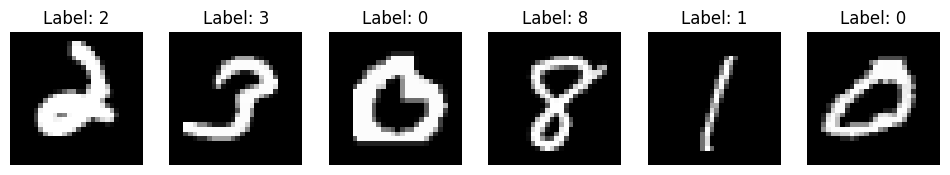

In [16]:
images = images * 0.5 + 0.5 

fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray') 
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()

### 2. Inicialización de pesos

Inicialización de Xavier (o Glorot): Ideal para redes con funciones de 
activación simétricas como tanh o sigmoid, y mejora la propagación de 
los gradientes en redes profundas.

Inicialización de He: Recomendada para redes con funciones de 
activación como ReLU, ya que ayuda a manejar el problema del 
desvanecimiento de gradientes.

Sugerencia de análisis: Comparar los resultados obtenidos con cada 
optimizador e inicialización utilizando métricas como la pérdida de 
entrenamiento y precisión, además de visualizar las curvas de aprendizaje 
para cada configuración.

#### 2.1 Inicialización de Xavier

La inicialización de Xavier (también conocida como Glorot) se usa típicamente con activaciones sigmoides o tangentes hiperbólicas (tanh). La función de Xavier ajusta los pesos para que sigan una distribución uniforme o normal con una varianza específica que ayuda a estabilizar la activación en cada capa.

In [16]:
def init_xavier(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight) 
            if layer.bias is not None:
                nn.init.zeros_(layer.bias) 

#### 2.2 Inicialización de He

La inicialización de He es ideal cuando se utilizan activaciones ReLU o variantes de ReLU, ya que adapta la varianza de los pesos a la cantidad de neuronas en la capa anterior, ayudando a que las activaciones no se saturen ni se apaguen.

In [17]:
def init_he(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu') 
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

### 3. Optimización

Algoritmos de optimización

##### 3.1 SGD (Descenso de Gradiente Estocástico)

In [18]:
def get_sgd_optimizer(model, lr=0.01, weight_decay=0):
    """SGD Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr,  weight_decay=weight_decay)

##### 3.2 SGD con Momentum

In [19]:
def get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9, weight_decay=0):
    """SGD with Momentum Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

##### 3.3 SGD con Nesterov Momentum

In [20]:
def get_sgd_nesterov_optimizer(model, lr=0.01, momentum=0.9, weight_decay=0):
    """SGD with Nesterov Momentum Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)

##### 3.4 RMSProp

In [21]:
def get_rmsprop_optimizer(model, lr=0.01, alpha=0.99):
    """RMSProp Optimizer"""
    return torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)

##### 3.5 Adam

In [22]:
def get_adam_optimizer(model, lr=0.01, betas=(0.9, 0.999)):
    """Adam Optimizer"""
    return torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

### 4. Regularización

##### 4.1 Dropout

Dropout ayuda a reducir el sobreajuste apagando aleatoriamente ciertas unidades durante el entrenamiento. Puedes definir una función que añada capas de dropout a un modelo

In [23]:
class DropoutFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_prob=0.5):
        super(DropoutFFNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)
        self.dropout = nn.Dropout(p=dropout_prob)  # prob de apagar neuronas

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        h1 = torch.tanh(self.fc1(x))
        h1 = self.dropout(h1)
        h2 = torch.tanh(self.fc2(h1))
        h2 = self.dropout(h2)
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total


##### 4.2 Batch Normalization

Batch Normalization se puede aplicar a las capas de manera similar. Esto ayuda a estabilizar el entrenamiento al mantener las activaciones de cada capa en un rango adecuado.

In [ ]:
class BatchNormFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1):
        super(BatchNormFFNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)  
        self.bn2 = nn.BatchNorm1d(hidden_size2)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        h1 = torch.tanh(self.fc1(x))
        h1 = self.bn1(h1)
        h2 = torch.tanh(self.fc2(h1))
        h2 = self.bn2(h2)
        
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total


##### 4.3 Batch Normalization con Dropout con misma probabilidad por capa

In [25]:
class BatchNormDropoutFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_rate=0.5):
        super(BatchNormDropoutFFNN, self).__init__()        
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.fc3 = nn.Linear(hidden_size2, output_size, bias=True)        
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        h1 = self.fc1(x)
        h1 = self.bn1(h1)
        h1 = torch.tanh(h1)
        h1 = self.dropout(h1)
        
        h2 = self.fc2(h1)
        h2 = self.bn2(h2)
        h2 = torch.tanh(h2)
        h2 = self.dropout(h2)
        
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

##### 4.4 Regularización L2

La regularización L2 (también llamada decaimiento de peso) se puede agregar directamente en el optimizador, y su valor será aplicado a cada parámetro del modelo.

In [26]:
def l2_regularization(model, lambda_l2):
    l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
    return lambda_l2 * l2_norm

### 5. Implementación del modelo

Se define una función para graficar las curvas de pérdida de entrenamiento y validación.

In [27]:
def plot_training_times(times):
    epoch_times = times["epoch_times"]
    train_times = times["train_times"]
    val_times = times.get("val_times")

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(epoch_times) + 1), epoch_times, label='Tiempo total por época', marker='o', linestyle='-')
    plt.plot(range(1, len(train_times) + 1), train_times, label='Tiempo de entrenamiento', marker='s', linestyle='--')
    if val_times:
        plt.plot(range(1, len(val_times) + 1), val_times, label='Tiempo de validación', marker='^', linestyle=':')

    plt.title('Tiempos por época durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Tiempo (segundos)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [202]:
def plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path) 
    plt.show()
    plt.close()

In [203]:
def plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path) 
    plt.show()
    plt.close()

In [30]:
def calculate_stats(times):
    epoch_avg = sum(times["epoch_times"]) / len(times["epoch_times"])
    train_avg = sum(times["train_times"]) / len(times["train_times"])
    val_avg = sum(times["val_times"]) / len(times["val_times"]) if times.get("val_times") else None
    epoch_max = max(times["epoch_times"])
    train_max = max(times["train_times"])
    val_max = max(times["val_times"]) if times.get("val_times") else None
    epoch_min = min(times["epoch_times"])
    train_min = min(times["train_times"])
    val_min = min(times["val_times"]) if times.get("val_times") else None
    return {
        "epoch": {"avg": epoch_avg, "max": epoch_max, "min": epoch_min},
        "train": {"avg": train_avg, "max": train_max, "min": train_min},
        "val": {"avg": val_avg, "max": val_max, "min": val_min} if times.get("val_times") else None
    }

#### 5.1 Random Dataset

##### 5.1.0 Definición de loop y otros

nn.BCELoss Binary Cross Entropy Loss: : Diseñada para tareas de clasificación binaria (una sola salida por muestra)

nn.CrossEntropyLoss Cross Entropy Loss: Diseñada para tareas de clasificación multiclase (incluye clasificación binaria como caso especial)

Entrenamiento del modelo:

In [31]:
def train_model_loop(model, optimizer, 
                     train_loader, 
                     val_loader=None, 
                     epochs=20, 
                     reports_every=1, 
                     device='cuda',
                     binary=True, 
                     l2=False, 
                     use_early_stopping=False, 
                     patience=5,
                     return_times=False
                     ):
    device = device if torch.cuda.is_available() else 'cpu'
    model.to(device)

    print('Model:', model)
    print('Number of parameters:', model.num_parameters())
    l2_lambda = 0.001
    loss = nn.BCELoss()
    if not binary:
        loss = nn.CrossEntropyLoss()
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], [] 
    epoch_times, train_times, val_times = [], [], []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    epoch_time_total = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_start_time = time.time()

        start_time_epoch = time.time()
        epoch_train_loss = 0
        correct_train, total_train = 0, 0

        for inputs, targets in train_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model.forward(inputs)
            L = loss(predictions, targets)

            if l2: # regularización l2
                l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
                L += l2_lambda * l2_reg 

            L.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_train_loss += L.item()

            
            if binary:
                predictions_binary = (predictions >= 0.5).float()
                correct_train += (predictions_binary == targets).sum().item()
            else:
                predictions_classes = torch.argmax(predictions, dim=1)
                correct_train += (predictions_classes == targets).sum().item()

            total_train += targets.size(0)

        train_time = time.time() - train_start_time
        train_times.append(train_time)
        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        
        val_time = 0
        if val_loader:
            val_start_time = time.time()
            model.eval()
            val_loss = 0
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    predictions = model.forward(inputs)
                    L = loss(predictions, targets)
                    val_loss += L.item()
                    if binary:
                        predictions_binary = (predictions >= 0.5).float()
                        correct_val += (predictions_binary == targets).sum().item()
                    else:
                        predictions_classes = torch.argmax(predictions, dim=1)
                        correct_val += (predictions_classes == targets).sum().item()
                    total_val += targets.size(0)
                    
            val_time = time.time() - val_start_time
            val_times.append(val_time)
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(correct_val / total_val)

            if use_early_stopping:
                if val_losses[-1] < best_val_loss:
                    best_val_loss = val_losses[-1]
                    patience_counter = 0
                    best_model_state = model.state_dict() 
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"\nEarly stopping triggered after {epoch} epochs!")
                        model.load_state_dict(best_model_state) 
                        break

        epoch_time_total += time.time() - start_time_epoch
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        if epoch % reports_every == 0:
            train_acc_percent = train_accuracies[-1] * 100
            val_acc_percent = (val_accuracies[-1] * 100) if val_loader else 0
            val_loss_display = val_losses[-1] if val_loader else 0
            sys.stdout.write(
                f'\rEpoch:{epoch:03d} '
                f'Train Acc:{train_acc_percent:.2f}% Loss:{train_losses[-1]:.4f} '
                f'Val Acc:{val_acc_percent:.2f}% Loss:{val_loss_display:.4f} '
                f'Time/epoch:{epoch_time_total/epoch:.3f}s'
            )
            sys.stdout.flush()

    if return_times:
        times = {
            "epoch_times": epoch_times,
            "train_times": train_times,
            "val_times": val_times if val_loader else None
        }
        return train_losses, val_losses, train_accuracies, val_accuracies, times
    else:
        return train_losses, val_losses, train_accuracies, val_accuracies


Validación del modelo:

In [234]:
def evaluate_model(model, test_loader, binary=True, device='cuda'):
    model.eval()
    print(model)
    criterion = torch.nn.BCELoss() if binary else torch.nn.CrossEntropyLoss()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            if binary:
                predictions = (outputs >= 0.5).float() 
                correct_predictions += (predictions == targets).sum().item()
            else:
                predictions = torch.argmax(outputs, dim=1) 
                correct_predictions += (predictions == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100
    return avg_loss, accuracy

División del dataset en train - validation y test según 70%-15%-15%

In [ ]:
# INIT1
total_samples = 5000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=300)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Se definen lotes de cada subconjunto, organiza los datasets en lotes de tamaño 128 (y así aprovechar la capacidad de la gpu nvidia 4060ti 16gb) y los configura para su uso durante el entrenamiento, validación y prueba.
https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

In [71]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### 5.1.1 Inicialización de modelo y loop

EXP1: Se inicia con 400 y 300 neuronas por capa

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Number of parameters: 241001
Epoch:020 Train Acc:61.37% Loss:0.6613 Val Acc:51.07% Loss:0.7446 Time/epoch:0.073s

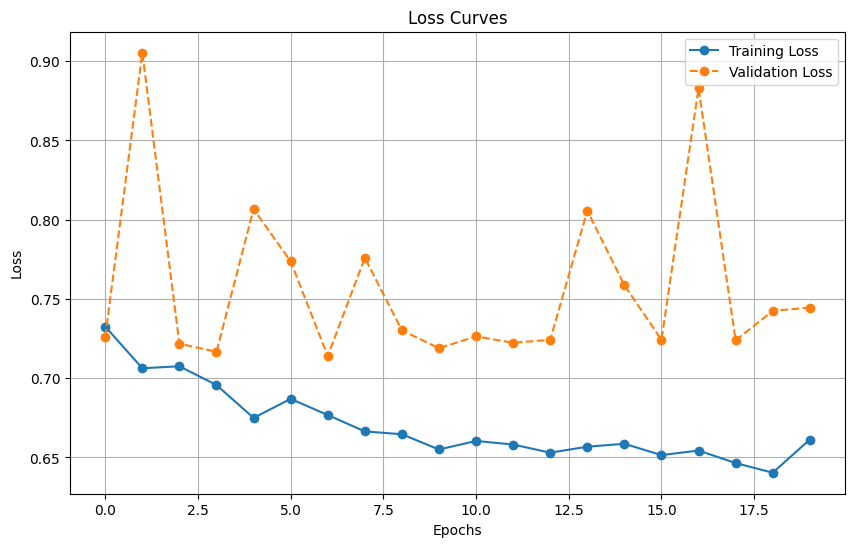

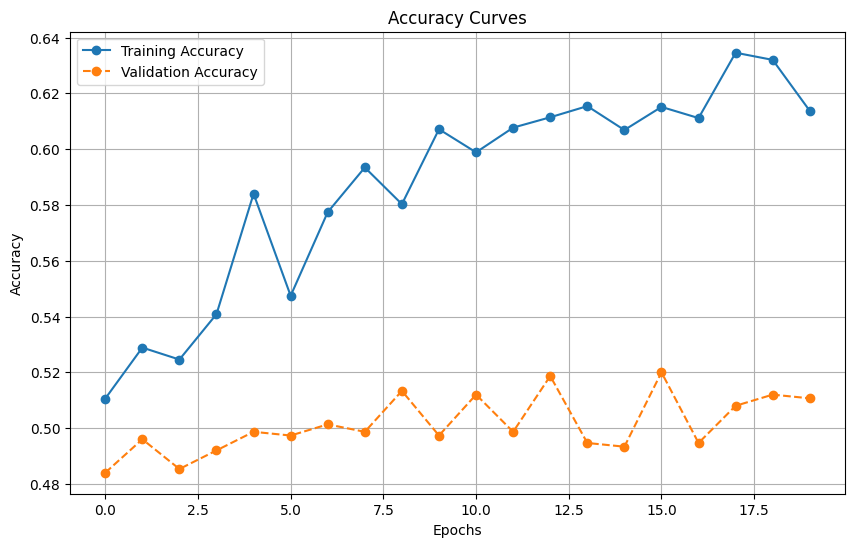

In [72]:
# EXP1
input_size = dataset.num_features 
hidden_size1 = 400
hidden_size2 = 300
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP2: Se aumentan la cantidad de neuronas por capa 

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
Number of parameters: 421401
Epoch:020 Train Acc:62.60% Loss:0.6447 Val Acc:49.73% Loss:0.7383 Time/epoch:0.050s

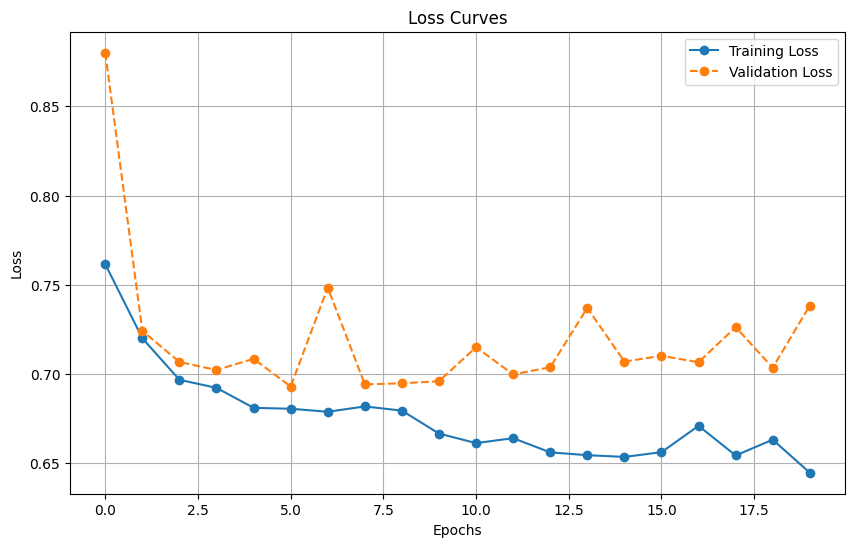

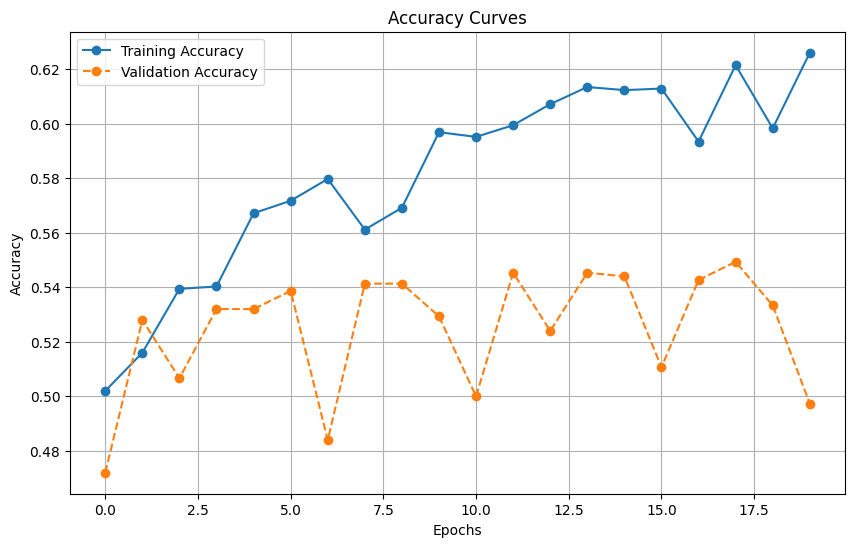

In [120]:
# EXP2
input_size = dataset.num_features 
hidden_size1 = 600
hidden_size2 = 400
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP3: Se siguen aumentando las neuroonas por capa

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=1, bias=True)
)
Number of parameters: 722001
Epoch:020 Train Acc:59.11% Loss:0.6713 Val Acc:53.73% Loss:0.7050 Time/epoch:0.050s

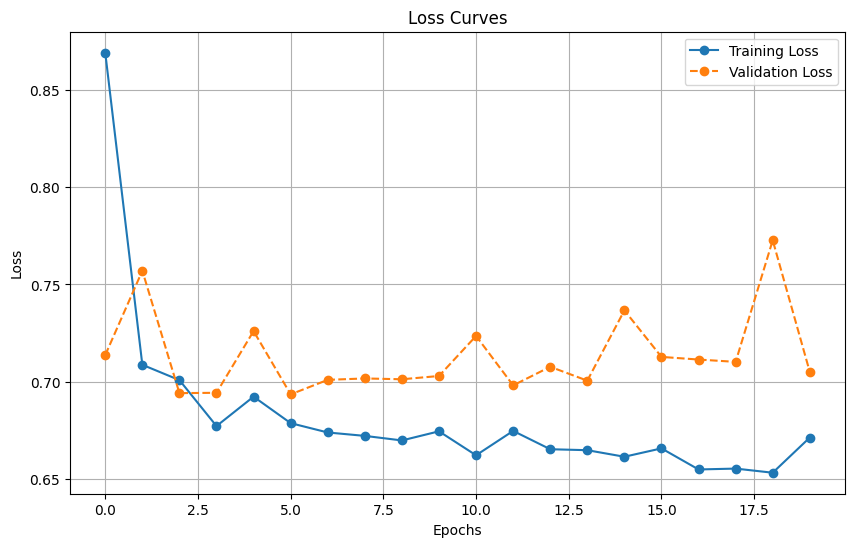

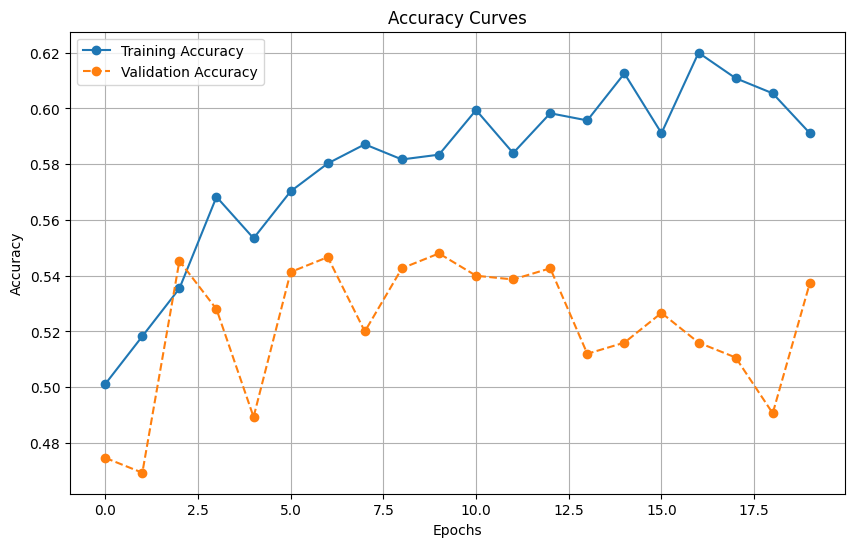

In [121]:
# EXP3
input_size = dataset.num_features 
hidden_size1 = 800
hidden_size2 = 600
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

##### 5.1.2 ¨Prueba de inicializaciones

EXP4: Se bajan la cantidad de neuronas por capa y se utiliza init_xavier

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:63.86% Loss:0.6413 Val Acc:54.40% Loss:0.7106 Time/epoch:0.049s

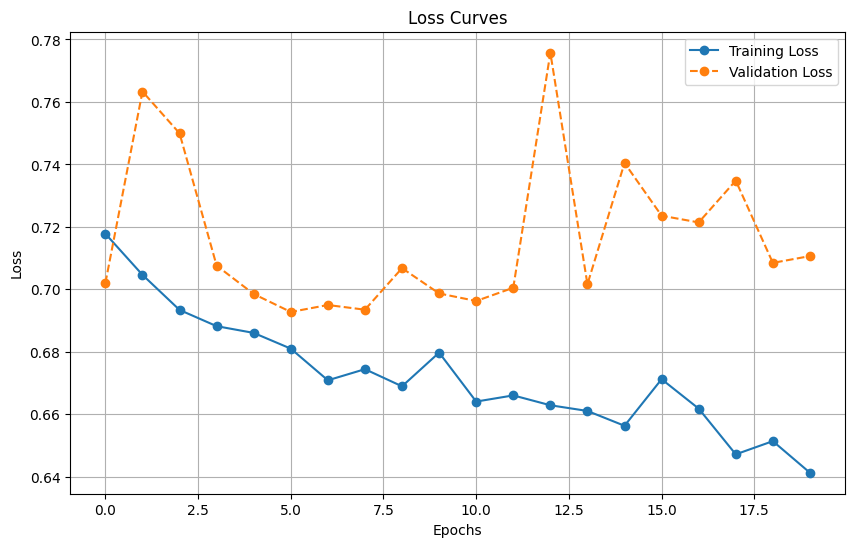

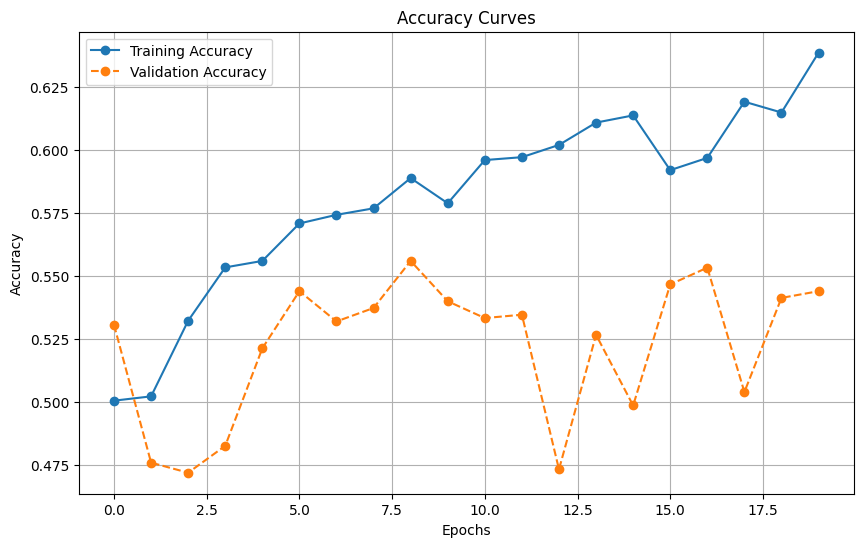

In [125]:
# EXP4
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP5: Se ejecuta de nuevo para poder validar que el accuracy ronda entre los 55 a 65 % en el train_loader y se utiliza init_he

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:67.00% Loss:0.6138 Val Acc:55.60% Loss:0.7076 Time/epoch:0.045s

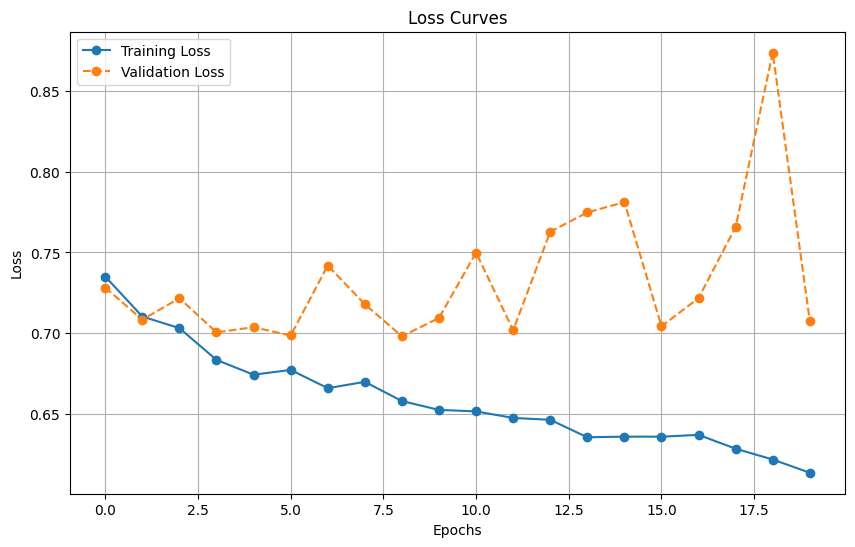

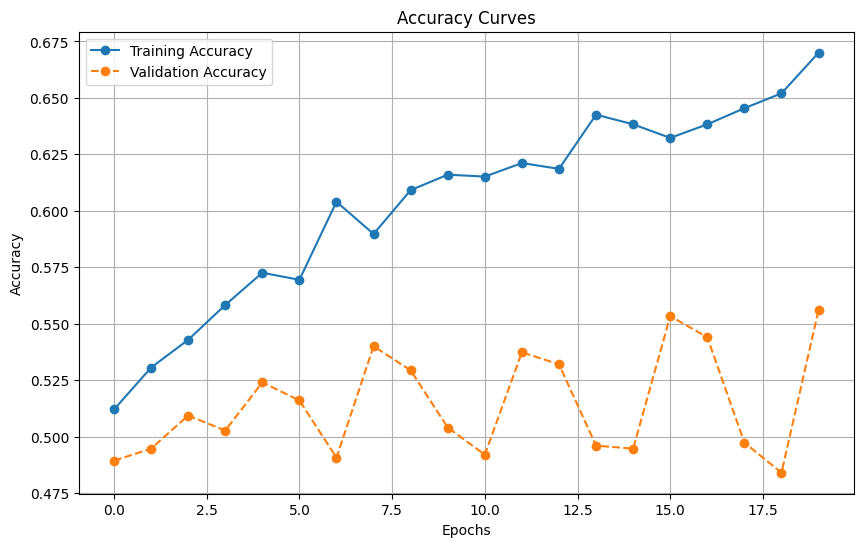

In [124]:
# EXP5
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

##### 5.1.3 Prueba de optimizadores

Definición de optimizadores en un arreglo para ejecutarlos de forma seguida

In [126]:
optimizers_to_test = [
    ("SGD", lambda model: get_sgd_optimizer(model, lr=0.01)),
    ("SGD + Momentum", lambda model: get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)),
    ("SGD + Nesterov", lambda model: get_sgd_nesterov_optimizer(model, lr=0.01, momentum=0.9)),
    ("RMSProp", lambda model: get_rmsprop_optimizer(model, lr=0.01, alpha=0.99)),
    ("Adam", lambda model: get_adam_optimizer(model, lr=0.01, betas=(0.9, 0.999)))
]
initializations_to_test = [
    ("Xavier", init_xavier),
    ("He", init_he)
]

Definición de la misma red para todas las pruebas.

In [ ]:
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1

EXP6: Se prueban varios optimizadores para comparar sus resultados

In [129]:
# EXP6
results_df = []
optimizer_results = []

for init_name, init_fn in initializations_to_test:
    for opt_name, opt_fn in optimizers_to_test:
        print(f"Testing optimizer: {opt_name} with initialization: {init_name}")
        
        model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
        init_fn(model)  
        optimizer = opt_fn(model)
        
        train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=20,
            reports_every=1,
            device='cuda'
        )
        
        optimizer_results.append({
            "Initialization": init_name,
            "Optimizer": opt_name,
            "Final Train Loss": train_losses[-1],
            "Final Val Loss": val_losses[-1],
            "Final Train Accuracy": train_accuracies[-1],
            "Final Val Accuracy": val_accuracies[-1]
        })

results_df = pd.DataFrame(optimizer_results)

Testing optimizer: SGD with initialization: Xavier
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:58.49% Loss:0.6755 Val Acc:51.60% Loss:0.6985 Time/epoch:0.048sTesting optimizer: SGD + Momentum with initialization: Xavier
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:70.43% Loss:0.5832 Val Acc:53.47% Loss:0.7275 Time/epoch:0.041sTesting optimizer: SGD + Nesterov with initialization: Xavier
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1,

Resultados de Loss y Accuracy de EXP6 para el train

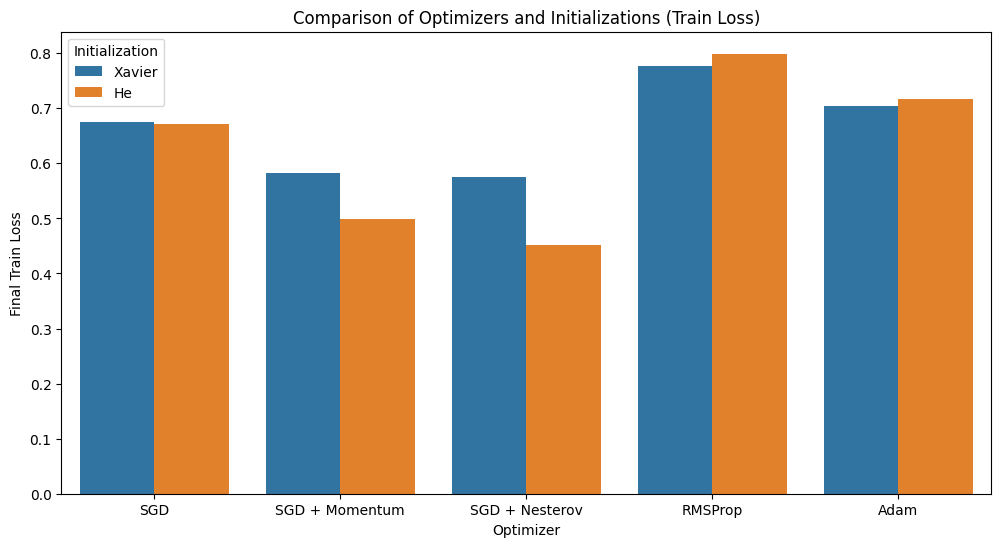

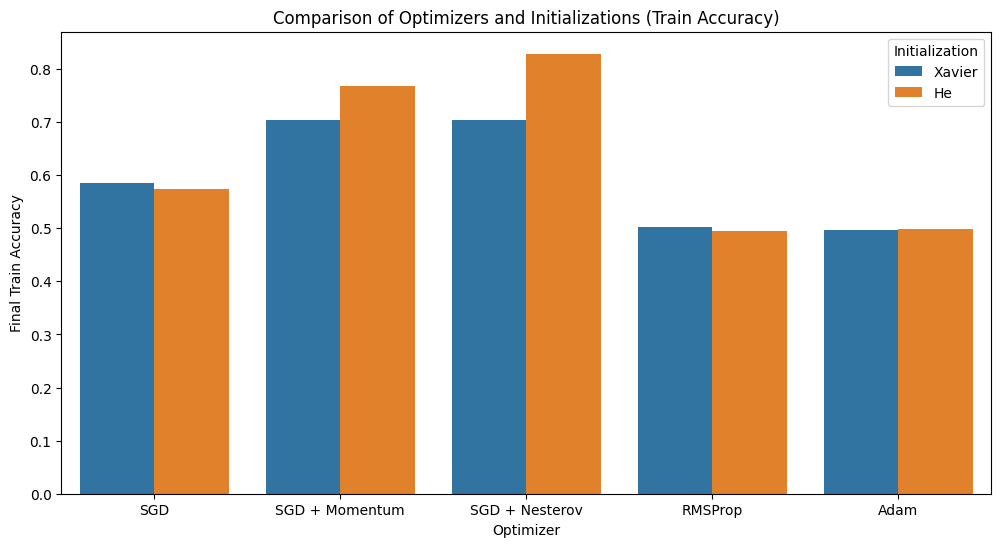

In [130]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Train Loss", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Train Loss)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Train Accuracy", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Train Accuracy)")
plt.show()

Resultados de Loss y Accuracy de EXP6 para el validation

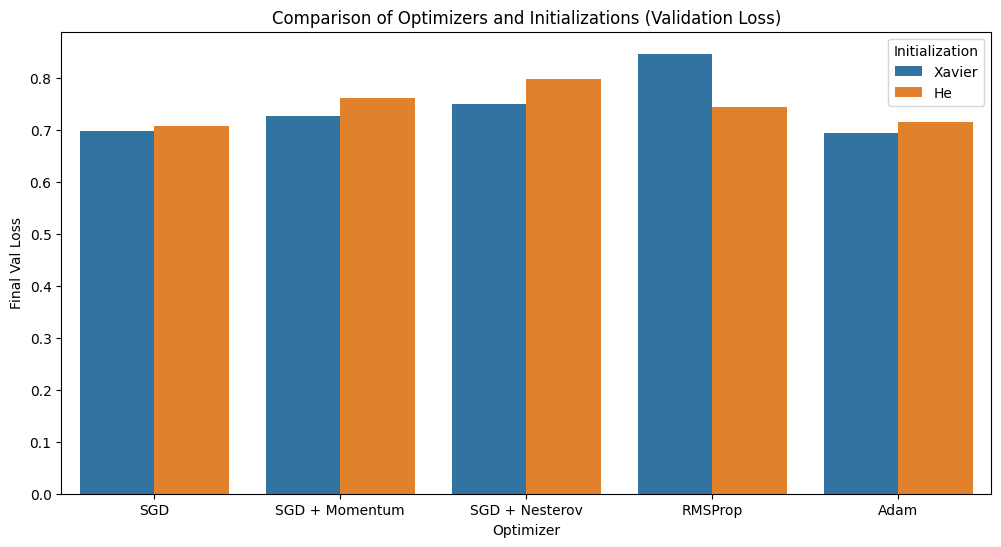

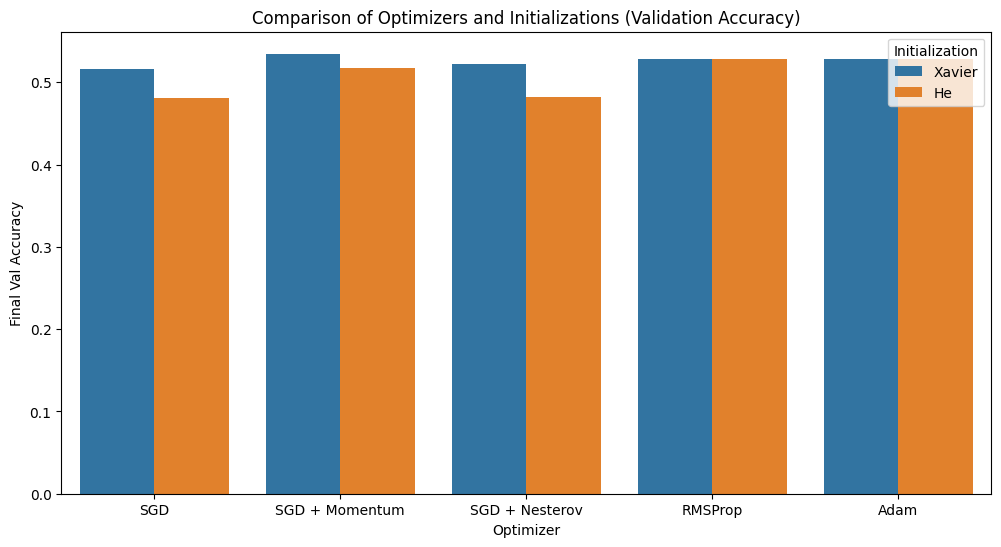

In [131]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Val Loss", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Validation Loss)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Optimizer", y="Final Val Accuracy", hue="Initialization")
plt.title("Comparison of Optimizers and Initializations (Validation Accuracy)")
plt.show()

El mejor enfoque parece ser SGD + Momentum, o SDG + Nesterov Optimizer, ya que proporciona menor loss y más accuracy en el train loader.

##### 5.1.3.1 Prueba de optimizadores e inicializaciones

EXP7: Se debe validar cuál es la menor inicialización de pesos, inicialización con he

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:100.00% Loss:0.0111 Val Acc:51.87% Loss:1.3294 Time/epoch:0.052s

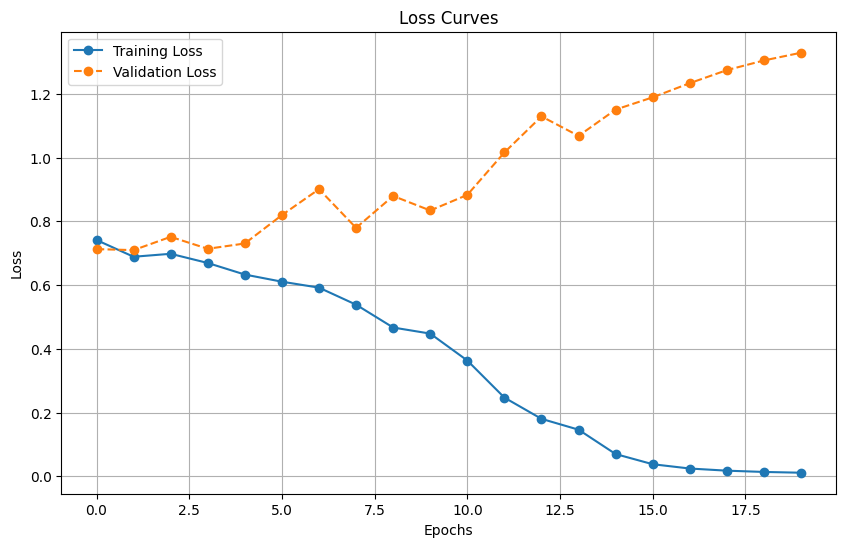

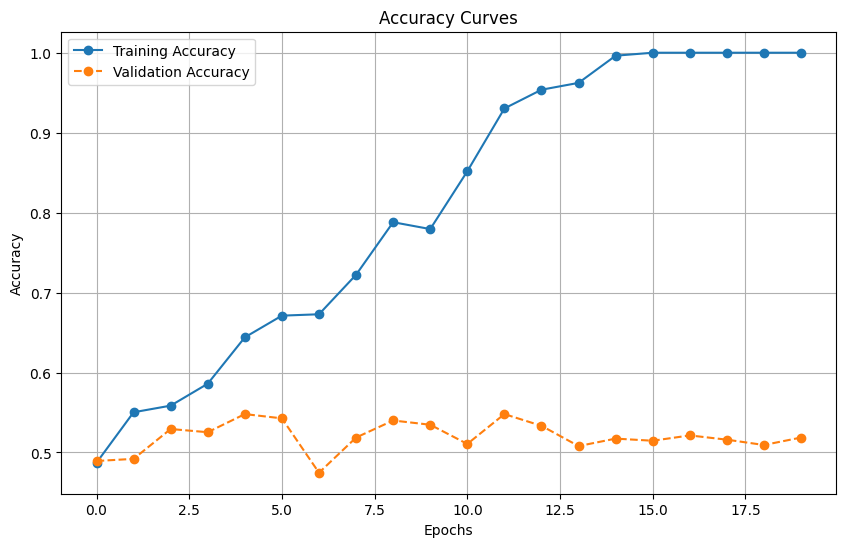

In [132]:
# EXP7
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_momentum_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP8: Inicialización con xavier + sgd momentum

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:97.03% Loss:0.1427 Val Acc:52.00% Loss:1.0558 Time/epoch:0.048s

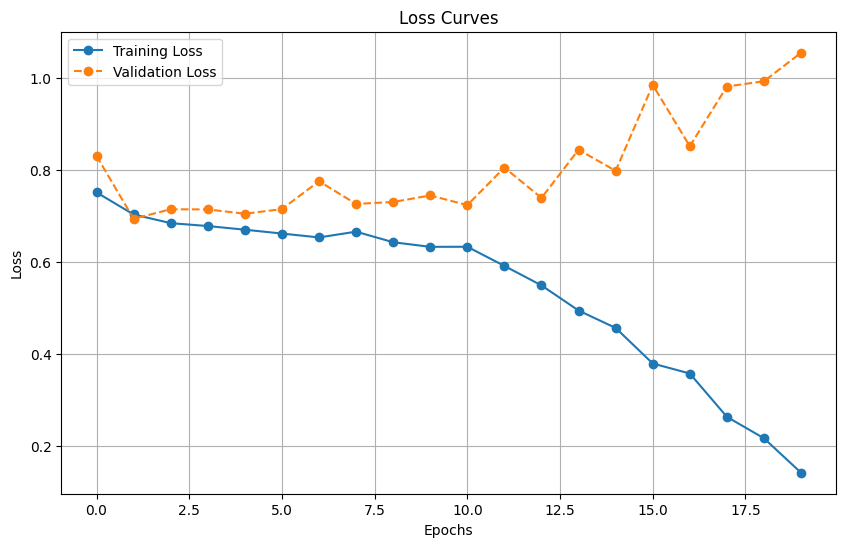

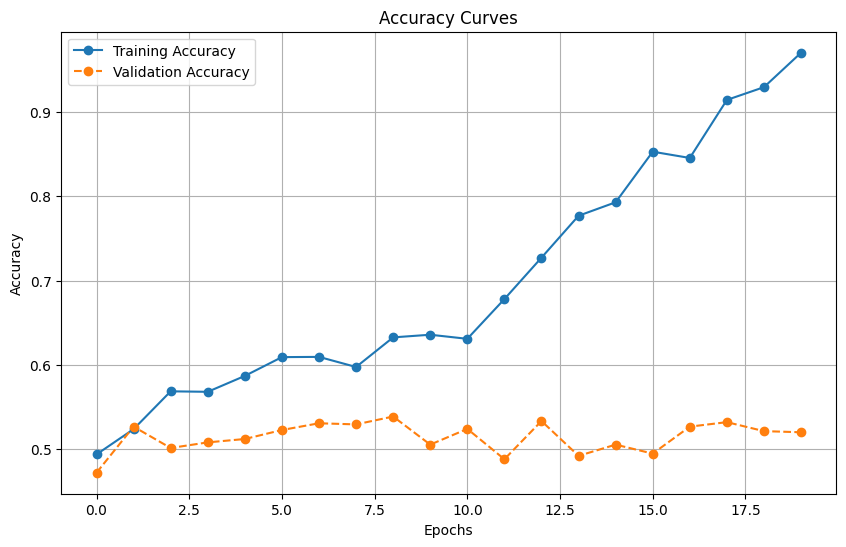

In [133]:
# EXP8
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_momentum_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP9: Init he + sgd nesterov

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:100.00% Loss:0.0129 Val Acc:52.40% Loss:1.3390 Time/epoch:0.048s

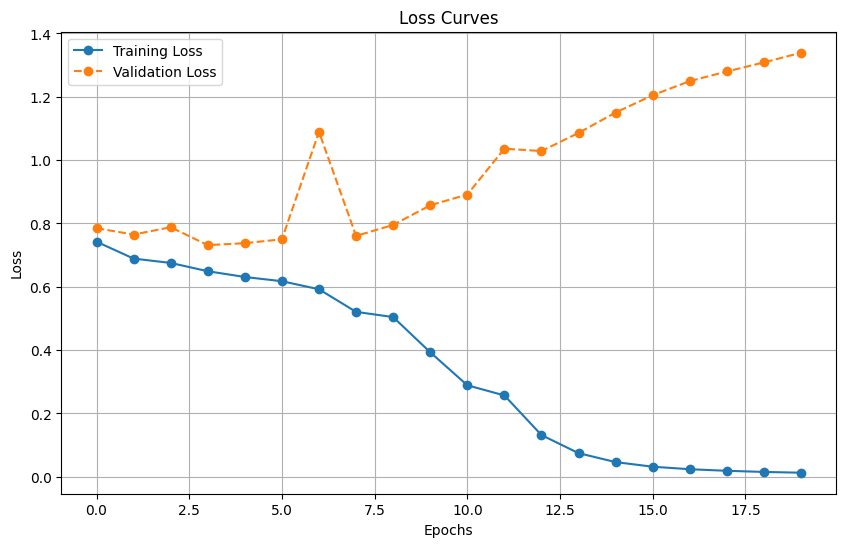

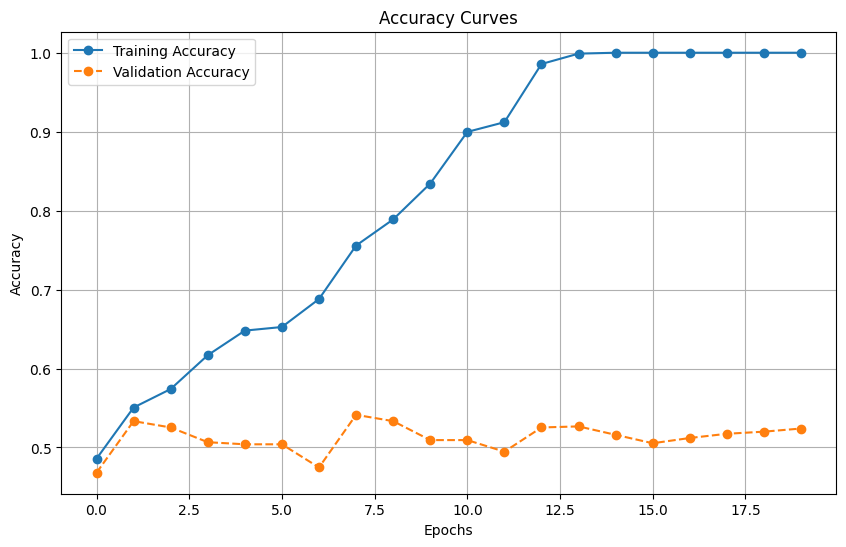

In [134]:
# EXP9
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP10: Inicialización de Xavier + sgd nesterov

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:100.00% Loss:0.0426 Val Acc:52.00% Loss:1.2716 Time/epoch:0.051s

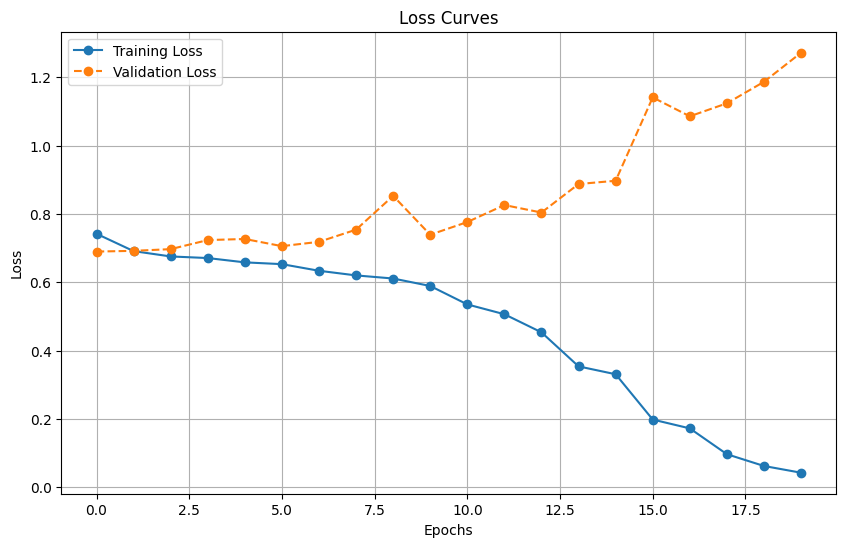

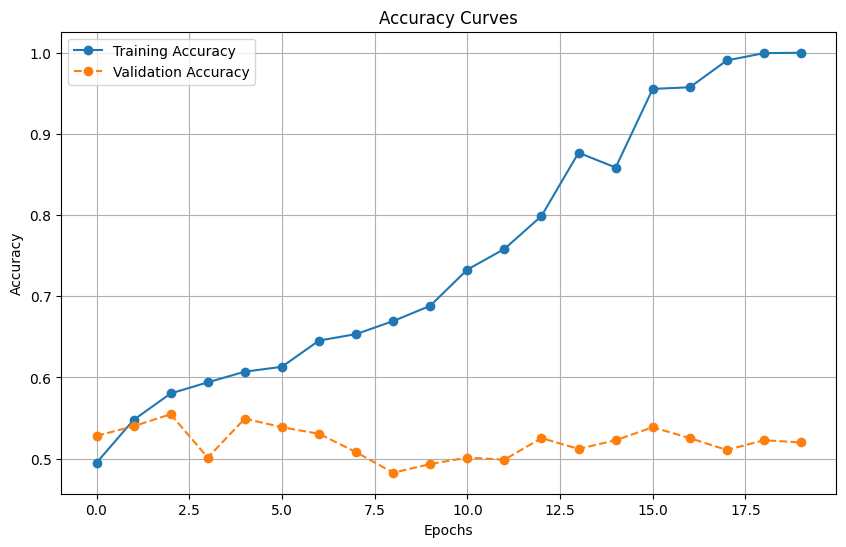

In [136]:
# EXP10
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

##### 5.1.4 Prueba de regularización

EXP11: Dropout

Model: DropoutFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 150701
Epoch:020 Train Acc:67.11% Loss:0.6094 Val Acc:53.47% Loss:0.7117 Time/epoch:0.063s

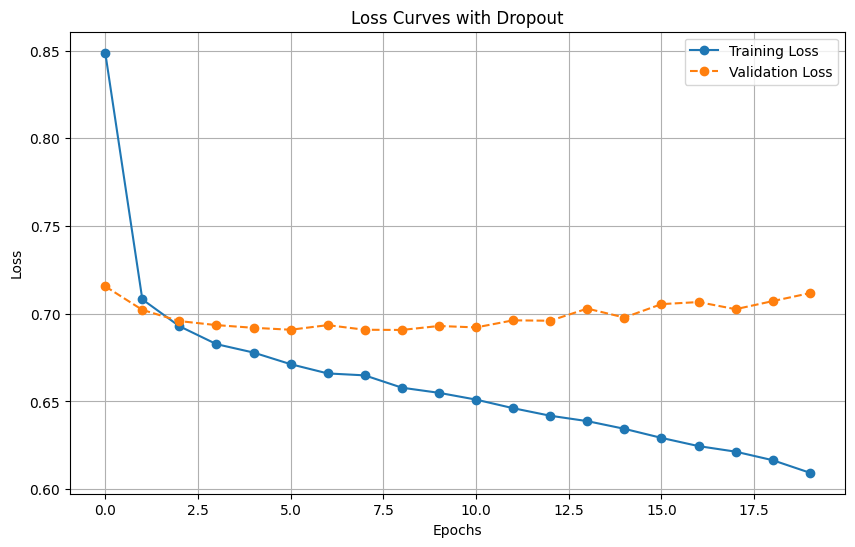

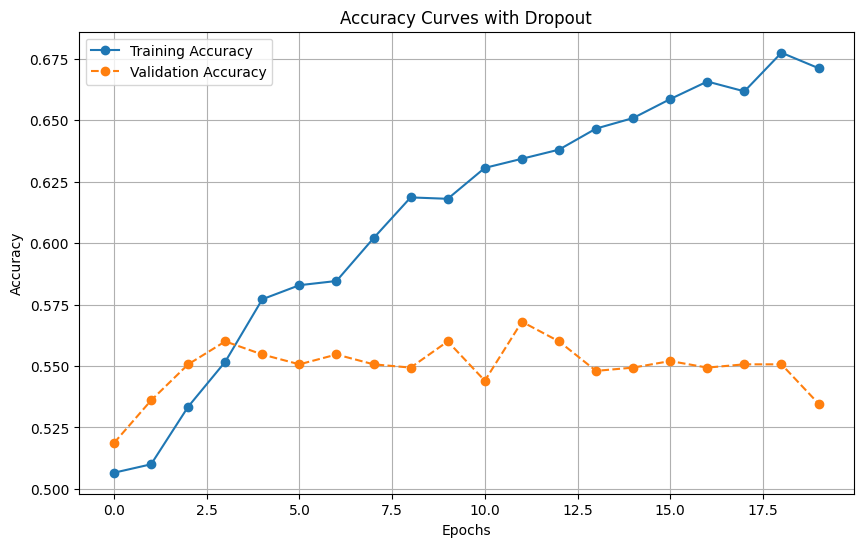

In [141]:
# EXP11
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1
model = DropoutFFNN(input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.005)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with Dropout")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with Dropout")

EXP12: Batch Normalization

Model: BatchNormFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 101401
Epoch:020 Train Acc:98.00% Loss:0.2403 Val Acc:52.40% Loss:0.8546 Time/epoch:0.073s

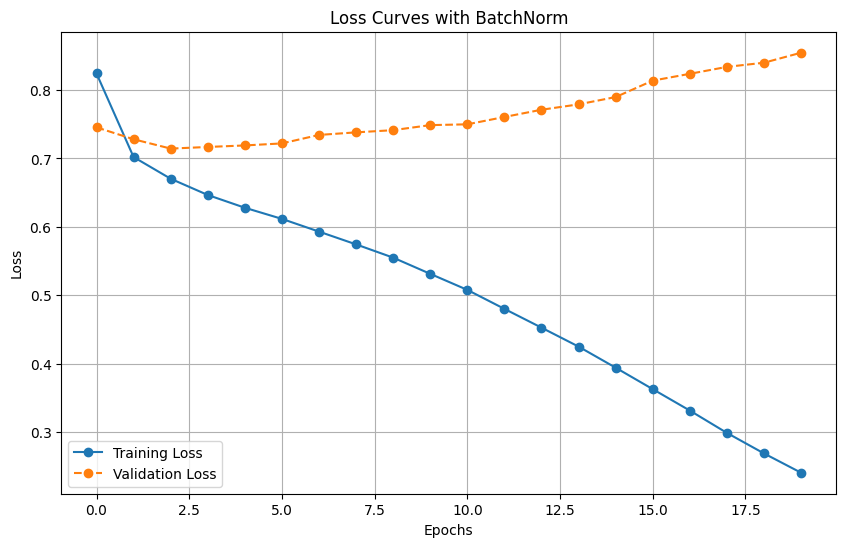

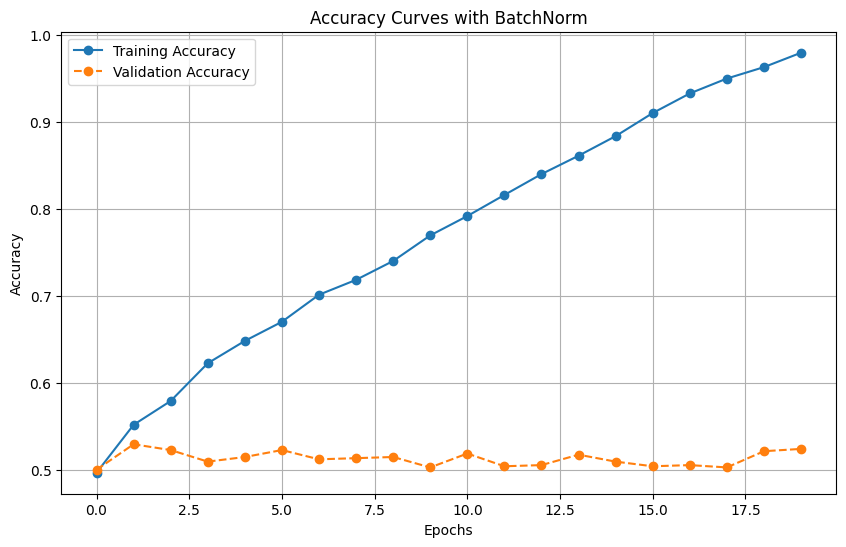

In [142]:
# EXP12
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1
model = BatchNormFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_nesterov_optimizer(model, lr=0.005)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

EXP13: Batch Normalization con Dropout

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 101401
Epoch:020 Train Acc:69.80% Loss:0.5940 Val Acc:52.67% Loss:0.7220 Time/epoch:0.057s

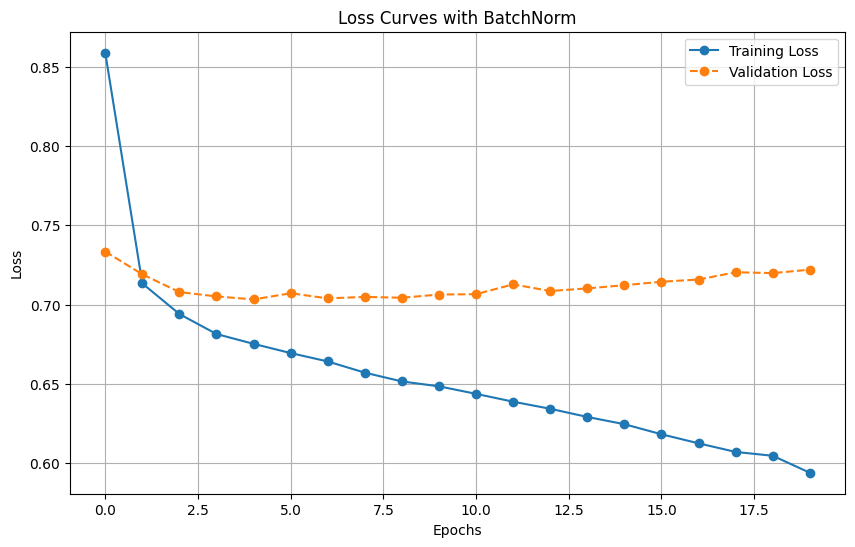

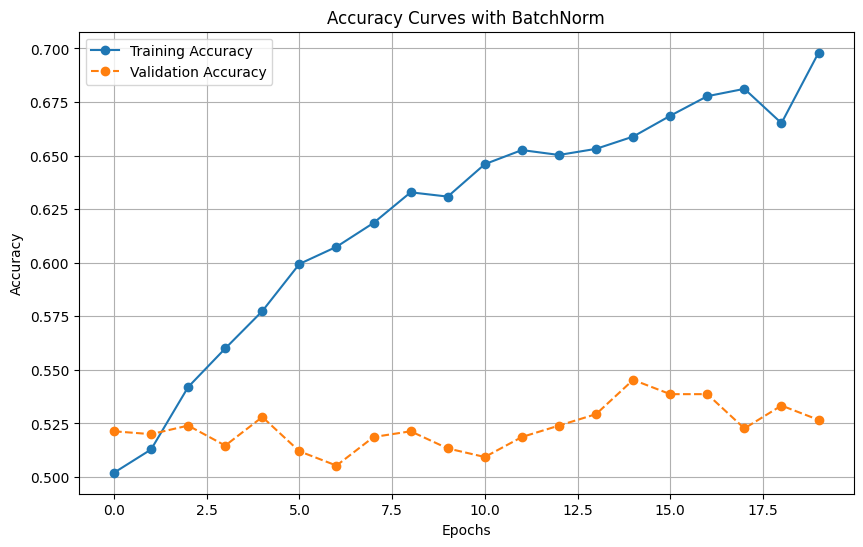

In [143]:
# EXP13
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_momentum_optimizer(model, lr=0.005)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

Regularización l2

EXP14: La regularización L2 se implementa directamente en el cálculo de la función de pérdida.

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:98.60% Loss:0.6220 Val Acc:52.67% Loss:1.0216 Time/epoch:0.064s

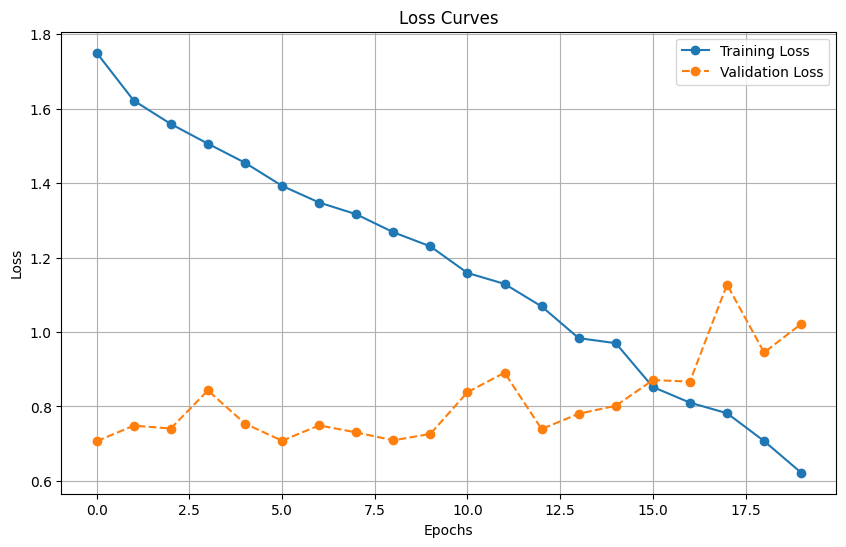

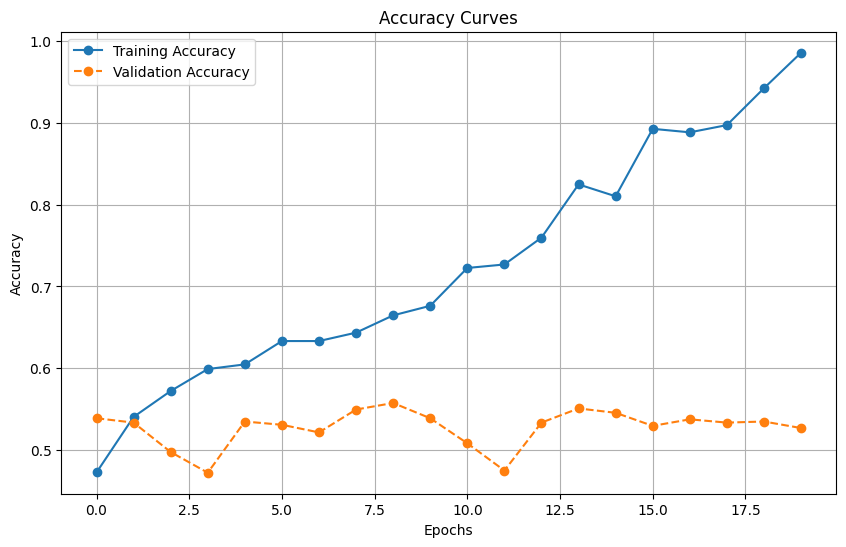

In [147]:
# EXP14
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    l2=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP15: El término weight_decay en los optimizadores de PyTorch introduce la regularización L2 de forma implícita en el proceso de actualización de parámetros:

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:100.00% Loss:0.0345 Val Acc:50.27% Loss:1.1898 Time/epoch:0.053s

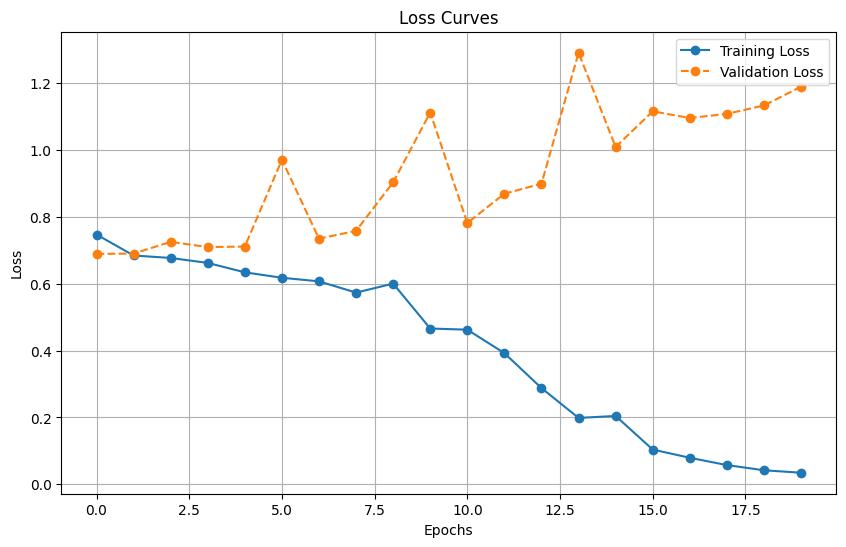

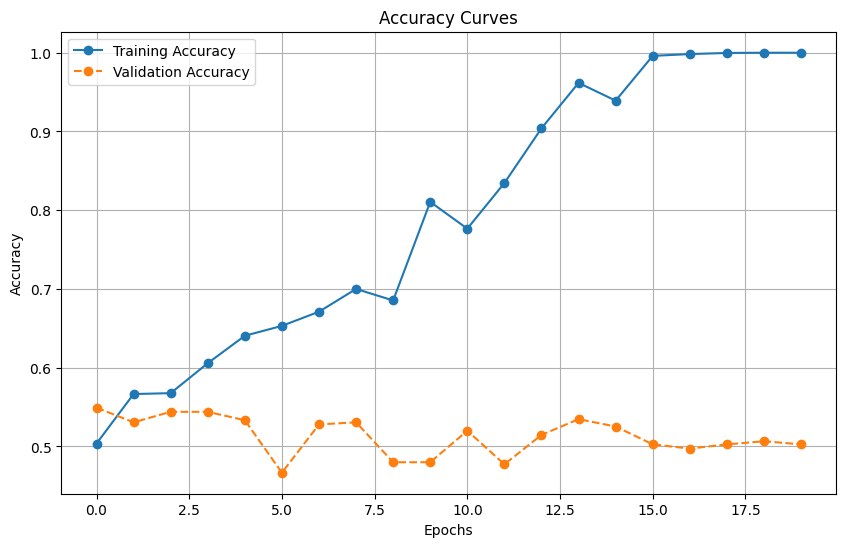

In [148]:
# EXP15
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

EXP16:Técnicas de Regularización Juntas

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 101401
Epoch:020 Train Acc:93.40% Loss:0.2351 Val Acc:52.93% Loss:1.0928 Time/epoch:0.053s

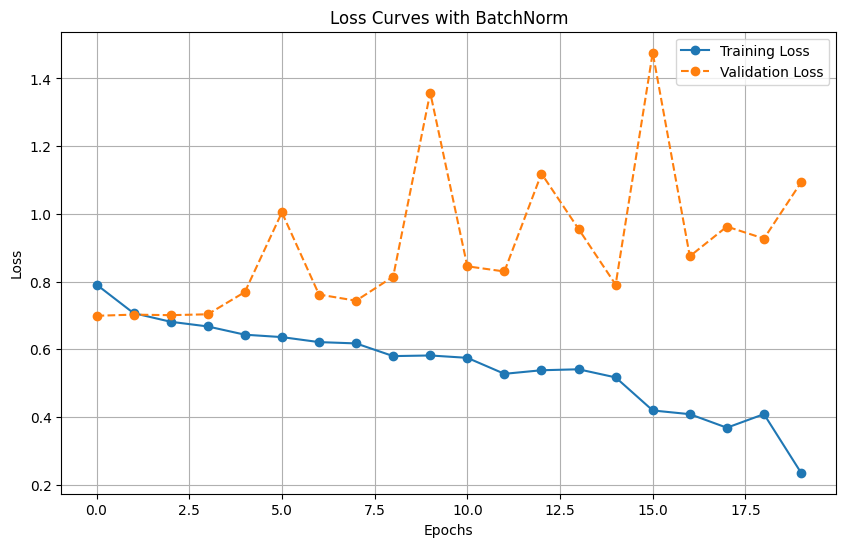

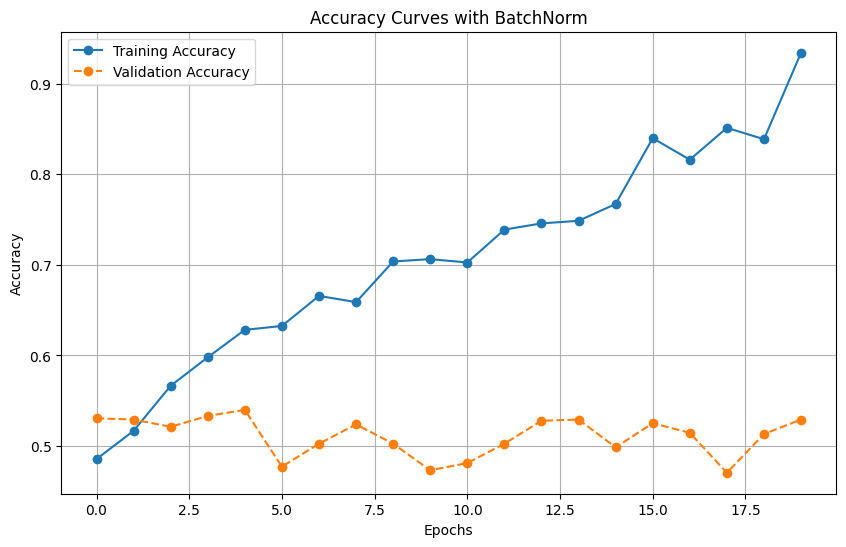

In [ ]:
# EXP16
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

EXP17: Agregando Early Stopping; https://pythonguides.com/pytorch-early-stopping/

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 101401
Epoch:013 Train Acc:62.80% Loss:0.6494 Val Acc:54.13% Loss:0.7053 Time/epoch:0.065s
Early stopping triggered after 14 epochs!


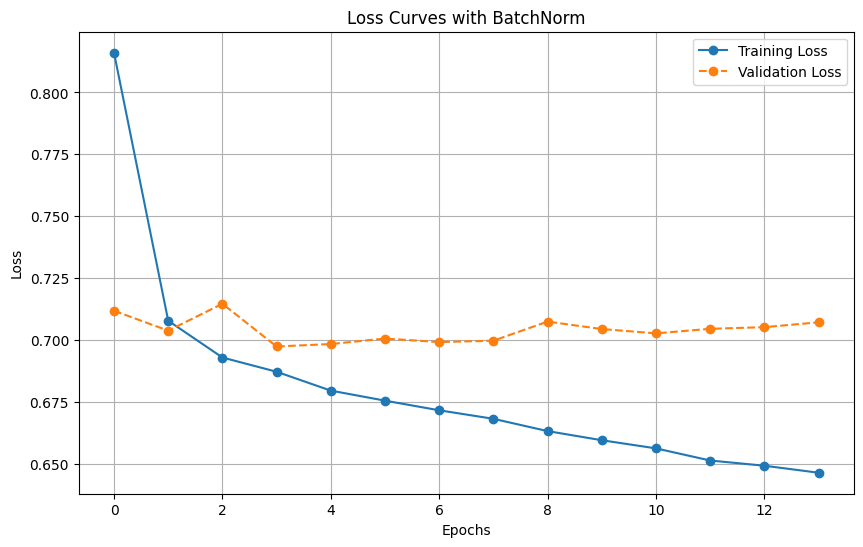

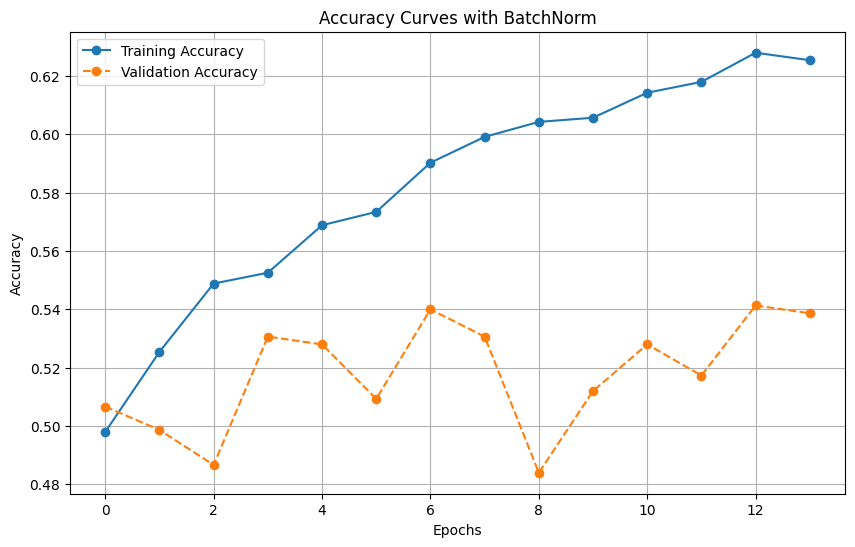

In [156]:
# EXP17
input_size = dataset.num_features 
hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=hidden_size2, hidden_size2=hidden_size2, output_size=output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True,
    patience=10
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")

##### 5.1.5 Prueba de modelo ensamble Bagging 
https://machinelearningmastery.com/bagging-ensemble-with-python

Generar Subconjuntos de Datos usando Bootstrap. La técnica de muestreo con reemplazo. Bootstrap Methods: Another Look at the Jackknife. Este método es ampliamente aceptado y se fundamenta en la idea de generar múltiples muestras del conjunto de datos original, permitiendo que una observación específica pueda aparecer más de una vez en una muestra (reemplazo). 

In [186]:
def create_bootstrap_samples(dataset, n_samples):
    return [random.randint(0, len(dataset) - 1) for _ in range(n_samples)]

Entrenar Varias Redes con Diferentes Subconjuntos: Bagging Predictors, Leo Breiman en 1996,  "The Elements of Statistical Learning", Hastie, Tibshirani y Friedman

La combinación de Subset y DataLoader en PyTorch es equivalente a la técnica de resampling mencionada en el trabajo de Breiman.

In [185]:
def train_ensemble(model_fn, optimizer_fn, train_dataset, val_loader=None, 
                   n_models=5, epochs=20, reports_every=1, device='cuda', binary=True, l2=False,  use_early_stopping=False):
    ensemble_models = []
    train_loaders = []
    ensemble_train_losses = []
    ensemble_val_losses = []
    ensemble_train_acc = []
    ensemble_val_acc = []
    
    for i in range(n_models):
        bootstrap_indices = create_bootstrap_samples(train_dataset, len(train_dataset))
        bootstrap_subset = Subset(train_dataset, bootstrap_indices)
        train_loader = DataLoader(bootstrap_subset, batch_size=32, shuffle=True)
        train_loaders.append(train_loader)
        
        model = model_fn()
        optimizer = optimizer_fn(model)
        
        print(f"\nTraining model {i + 1}/{n_models}...")
        train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
            model, optimizer, train_loader, val_loader,
            epochs=epochs, reports_every=reports_every,
            device=device, binary=binary, l2=l2, use_early_stopping=use_early_stopping
        )

        ensemble_train_losses.append(train_losses)
        ensemble_val_losses.append(val_losses)
        ensemble_train_acc.append(train_accuracies)
        ensemble_val_acc.append(val_accuracies)
        ensemble_models.append(model)
    
    return ensemble_models, ensemble_train_losses, ensemble_val_losses, ensemble_train_acc, ensemble_val_acc


In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [247]:
def create_model(input_size, hidden_size1, hidden_size2, output_size):
    return SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 

def create_optimizer(model):
    return get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)


EXP18: Bootstrap con técnicas de regularización, inicialización He, nesterov optimizer y simple FFNN sin use_early_stopping (no se agrega porque la validación en el random dataset va a cortar el entranmiento).

In [191]:
# EXP18
n_models = 8
epochs = 20
ensemble_models, train_losses, val_losses, train_acc, val_acc = train_ensemble(
    model_fn=lambda: create_model(input_size, hidden_size1, hidden_size2, output_size),
    optimizer_fn=create_optimizer,
    train_dataset=train_dataset,
    val_loader=val_loader,
    n_models=n_models,       
    epochs=epochs,   
    binary=True,
    use_early_stopping = False
)


Training model 1/8...
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:95.66% Loss:0.1095 Val Acc:48.67% Loss:1.7567 Time/epoch:0.137s
Training model 2/8...
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:94.89% Loss:0.1333 Val Acc:49.47% Loss:1.9117 Time/epoch:0.149s
Training model 3/8...
Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:94.09% Loss:0.1508 Val Acc:53.33% Loss:1.58

Resultados para EXP18

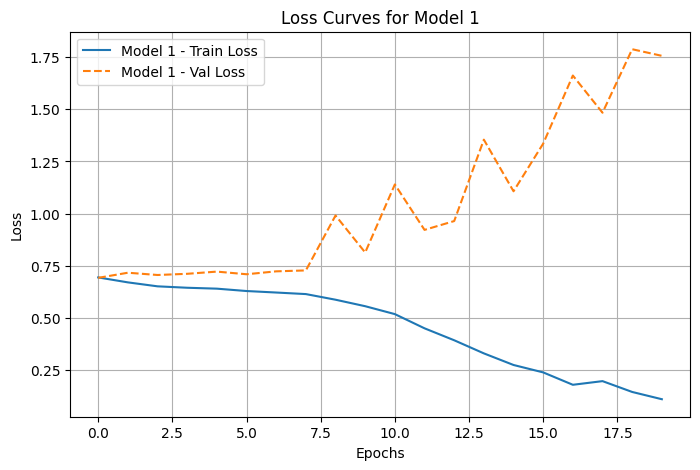

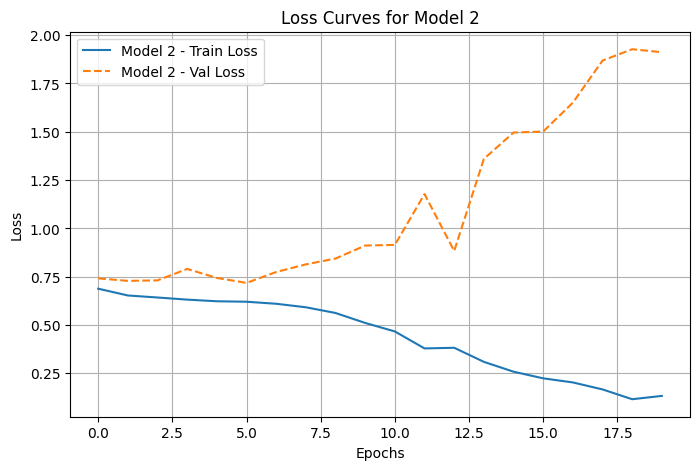

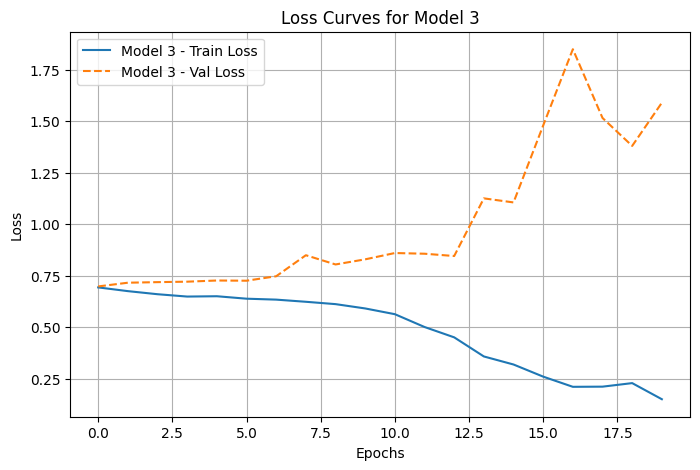

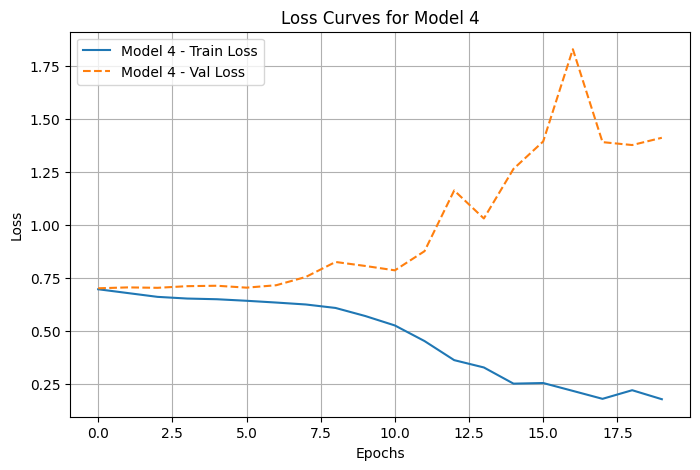

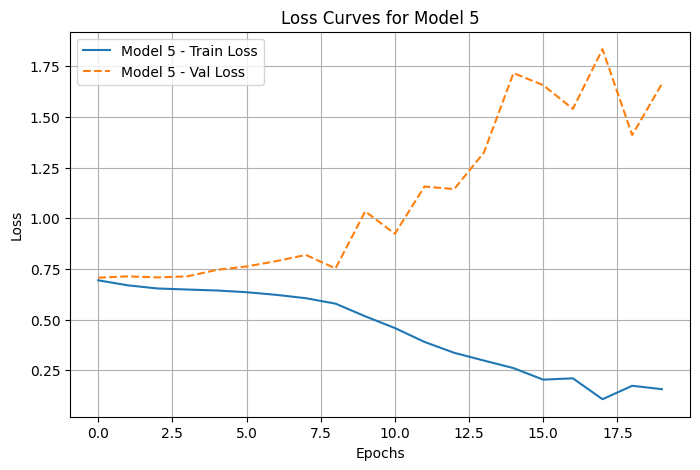

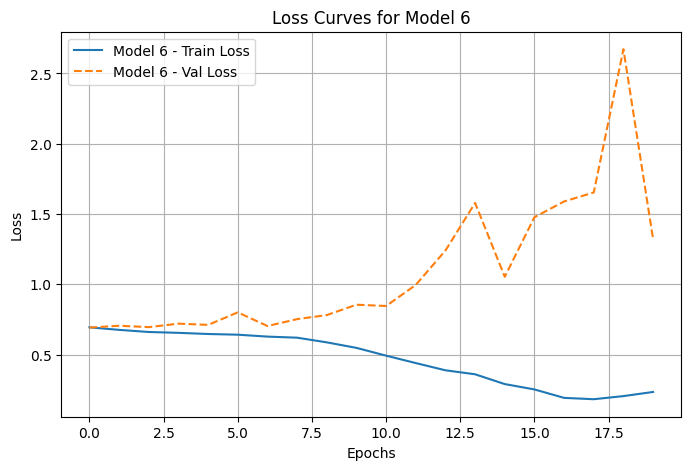

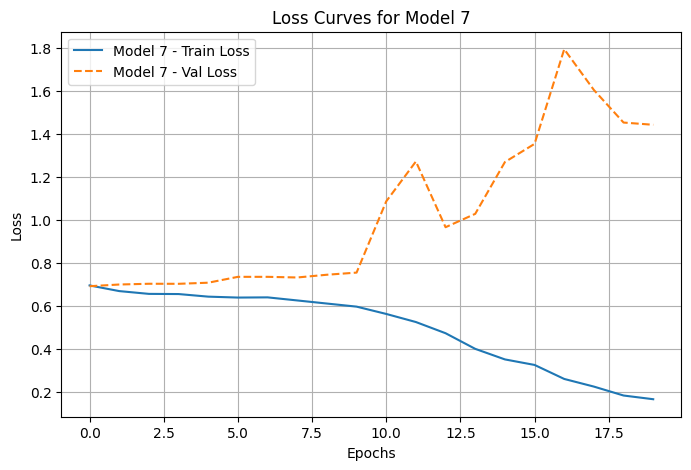

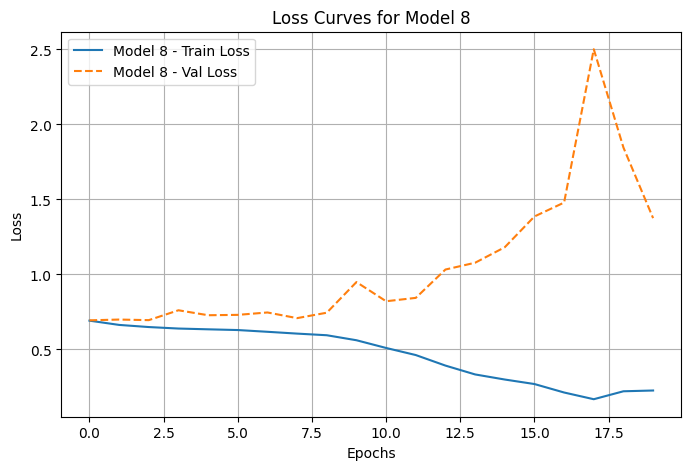

In [192]:
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label=f"Model {i+1} - Train Loss")
    plt.plot(val_loss, label=f"Model {i+1} - Val Loss", linestyle="--")
    plt.title(f"Loss Curves for Model {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [215]:
final_train_losses = [loss[-1] for loss in train_losses]
final_val_losses = [loss[-1] for loss in val_losses]

for i, (train_loss, val_loss) in enumerate(zip(final_train_losses, final_val_losses)):
    print(f"Model {i+1} - Final Train Loss: {train_loss:.4f}, Final Val Loss: {val_loss:.4f}")


Model 1 - Final Train Loss: 0.1095, Final Val Loss: 1.7567
Model 2 - Final Train Loss: 0.1333, Final Val Loss: 1.9117
Model 3 - Final Train Loss: 0.1508, Final Val Loss: 1.5899
Model 4 - Final Train Loss: 0.1766, Final Val Loss: 1.4096
Model 5 - Final Train Loss: 0.1563, Final Val Loss: 1.6631
Model 6 - Final Train Loss: 0.2341, Final Val Loss: 1.3216
Model 7 - Final Train Loss: 0.1682, Final Val Loss: 1.4443
Model 8 - Final Train Loss: 0.2267, Final Val Loss: 1.3756


In [193]:
def collect_predictions(ensemble_models, test_loader, device):
    ensemble_predictions = []
    true_labels = [] 
    first_model = True 
    for model in ensemble_models:
        model.eval()
        model.to(device)
        predictions = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                preds = model(inputs)
                predictions.append(preds)
                if first_model:
                    true_labels.extend(targets.cpu().numpy())
        first_model = False 
        ensemble_predictions.append(torch.cat(predictions, dim=0).cpu().numpy())
    return ensemble_predictions, true_labels

In [191]:
def evaluate_ensemble(ensemble_models, test_loader, device='cuda', binary=True):
    loss_fn = nn.BCELoss() if binary else nn.CrossEntropyLoss()
    ensemble_predictions, true_labels = collect_predictions(ensemble_models, test_loader, device)
    final_predictions = np.mean(np.stack(ensemble_predictions), axis=0)
    true_labels = np.array(true_labels)

    if binary:
        final_predictions = final_predictions.squeeze() 
        true_labels = true_labels.squeeze()             
        predictions_binary = (final_predictions >= 0.5).astype(int) 
    else:
        predictions_binary = np.argmax(final_predictions, axis=1) 

    print(f"Predictions Binary Shape: {predictions_binary.shape}")
    print(f"True Labels Shape: {true_labels.shape}")

    accuracy = (predictions_binary == true_labels).mean()
    final_predictions_tensor = torch.tensor(final_predictions).float()
    true_labels_tensor = torch.tensor(true_labels).float() if binary else torch.tensor(true_labels).long()
    loss = loss_fn(final_predictions_tensor, true_labels_tensor)
    return accuracy, loss.item()


Lo ideal es evaluar el ensamble, se hará acá para probar el código correctamente aunque los resultados esperados son negativos por el tipo de conjunto que se está trabajando.

In [283]:
#EXP18-1
accuracy, test_loss = evaluate_ensemble(
    ensemble_models=ensemble_models,
    test_loader=test_loader,
    device='cuda',
    binary=True
)

print(f"Ensemble Accuracy: {accuracy * 100:.2f}%")
print(f"Ensemble Test Loss: {test_loss:.4f}")

Predictions Binary Shape: (750,)
True Labels Shape: (750,)
Ensemble Accuracy: 46.53%
Ensemble Test Loss: 0.8479


##### 5.1.6 Pruebas extra con cuda y cpu

EXP19: Se desea medir el tiempo con cuda

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:99.59% Loss:0.0753 Val Acc:49.07% Loss:1.3328 Time/epoch:0.137s

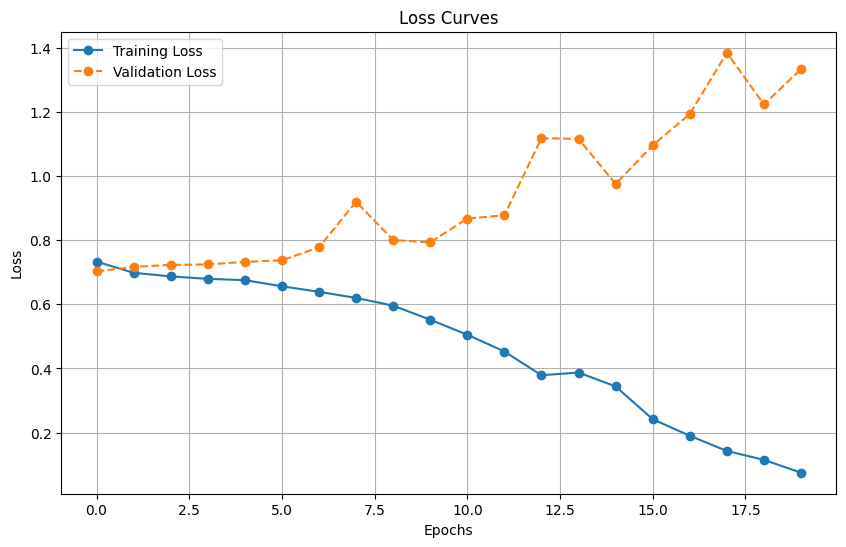

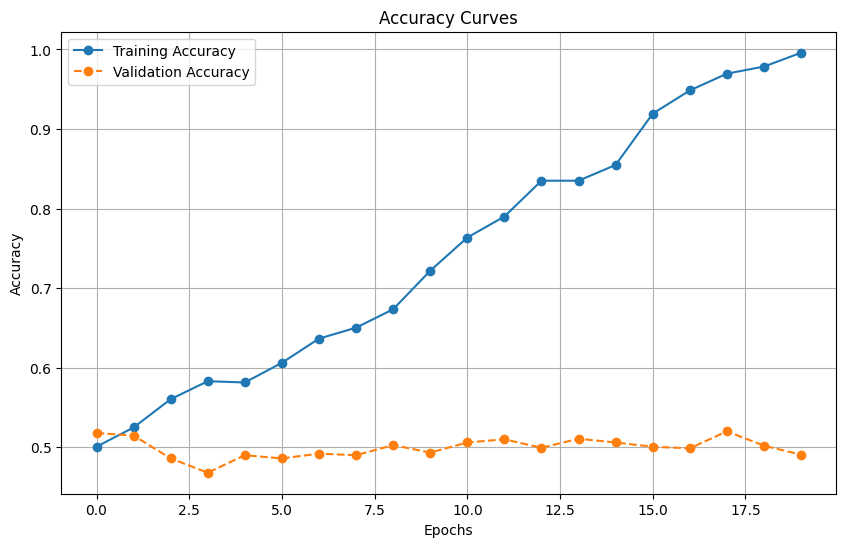

In [297]:
# EXP19
total_samples = 10000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=300)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_size = dataset.num_features 

hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies, times = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    return_times = True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

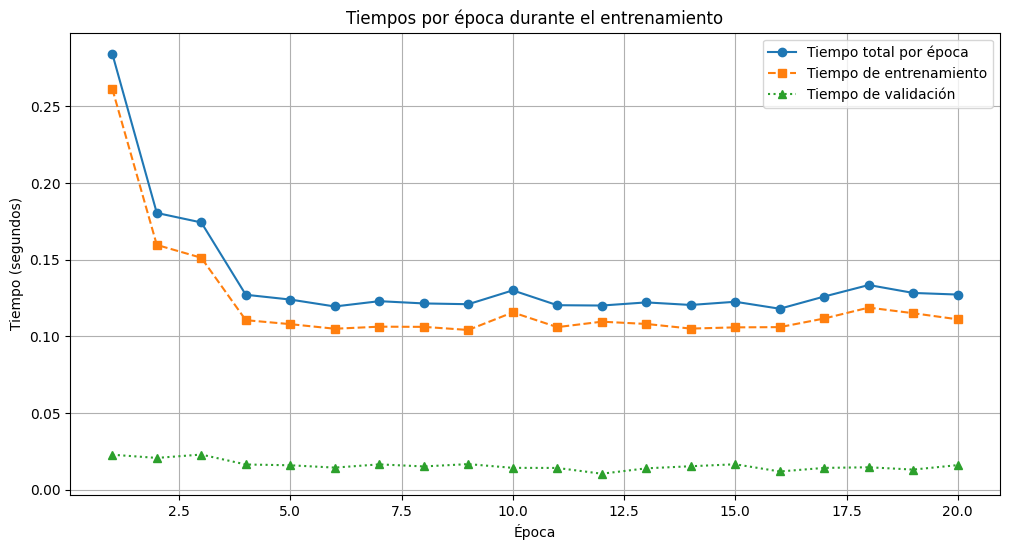

In [300]:
plot_training_times(times)

In [314]:
stats = calculate_stats(times)
print("=== Estadísticas de Tiempos GPU ===")
print(f"\nÉpocas:")
print(f"  Promedio: {stats['epoch']['avg']:.4f} s")
print(f"  Máximo:   {stats['epoch']['max']:.4f} s")
print(f"  Mínimo:   {stats['epoch']['min']:.4f} s")

print(f"\nEntrenamiento:")
print(f"  Promedio: {stats['train']['avg']:.4f} s")
print(f"  Máximo:   {stats['train']['max']:.4f} s")
print(f"  Mínimo:   {stats['train']['min']:.4f} s")

if stats['val']:
    print(f"\nValidación:")
    print(f"  Promedio: {stats['val']['avg']:.4f} s")
    print(f"  Máximo:   {stats['val']['max']:.4f} s")
    print(f"  Mínimo:   {stats['val']['min']:.4f} s")

=== Estadísticas de Tiempos GPU ===

Épocas:
  Promedio: 0.1372 s
  Máximo:   0.2843 s
  Mínimo:   0.1181 s

Entrenamiento:
  Promedio: 0.1213 s
  Máximo:   0.2614 s
  Mínimo:   0.1042 s

Validación:
  Promedio: 0.0159 s
  Máximo:   0.0230 s
  Mínimo:   0.0105 s


EXP20: se desea medir tiempos con cpu

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:99.40% Loss:0.0762 Val Acc:47.73% Loss:1.3538 Time/epoch:0.144s

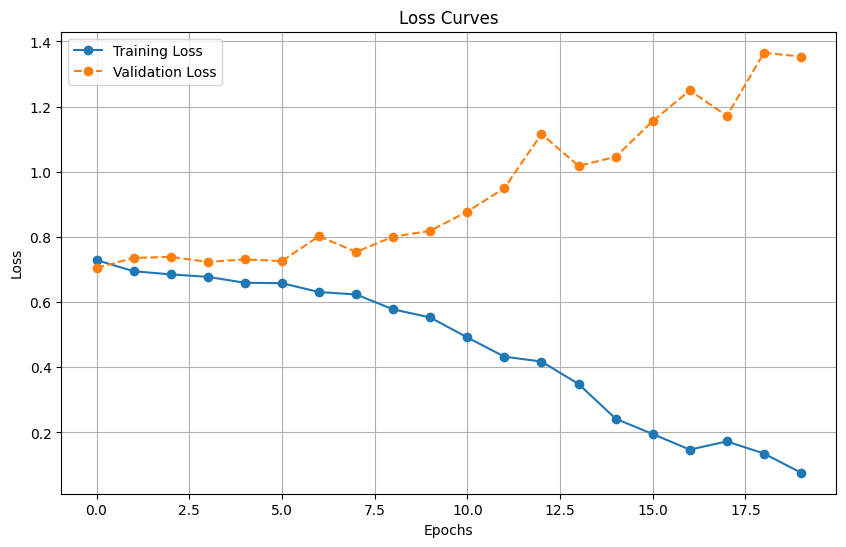

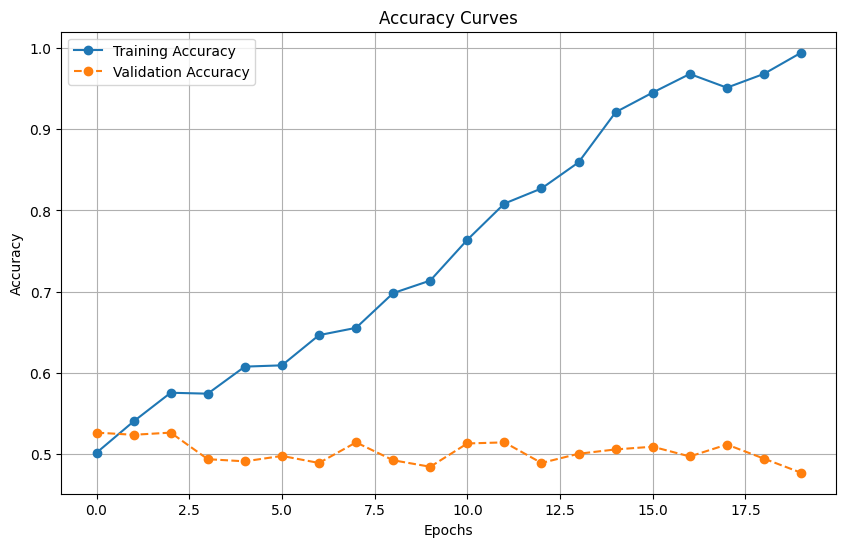

In [306]:
# EXP20
total_samples = 10000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=300)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_size = dataset.num_features 

hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies, times_cpu = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cpu',
    return_times = True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

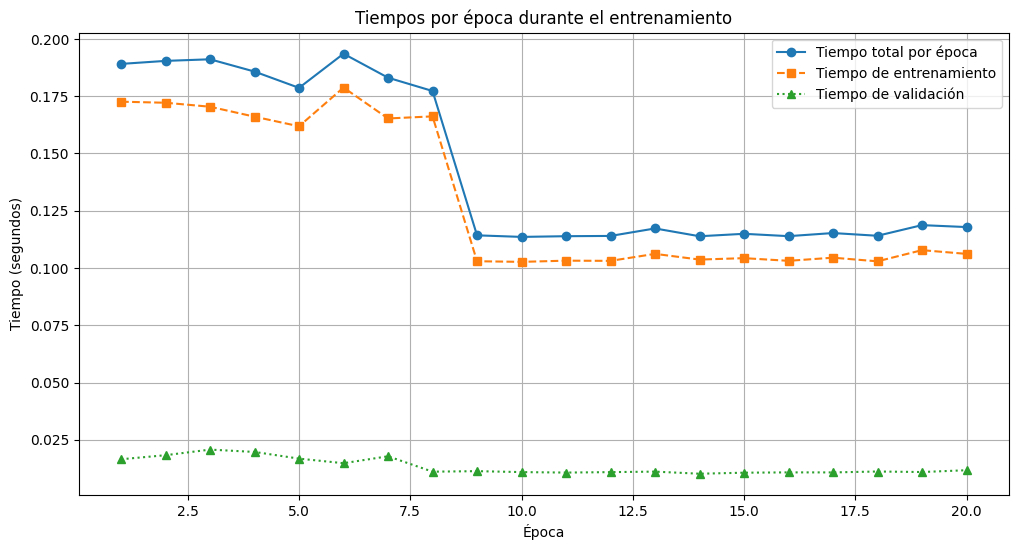

In [307]:
plot_training_times(times_cpu)

In [313]:
stats = calculate_stats(times_cpu)
print("=== Estadísticas de Tiempos CPU ===")
print(f"\nÉpocas:")
print(f"  Promedio: {stats['epoch']['avg']:.4f} s")
print(f"  Máximo:   {stats['epoch']['max']:.4f} s")
print(f"  Mínimo:   {stats['epoch']['min']:.4f} s")

print(f"\nEntrenamiento:")
print(f"  Promedio: {stats['train']['avg']:.4f} s")
print(f"  Máximo:   {stats['train']['max']:.4f} s")
print(f"  Mínimo:   {stats['train']['min']:.4f} s")

if stats['val']:
    print(f"\nValidación:")
    print(f"  Promedio: {stats['val']['avg']:.4f} s")
    print(f"  Máximo:   {stats['val']['max']:.4f} s")
    print(f"  Mínimo:   {stats['val']['min']:.4f} s")

=== Estadísticas de Tiempos CPU ===

Épocas:
  Promedio: 0.1435 s
  Máximo:   0.1935 s
  Mínimo:   0.1136 s

Entrenamiento:
  Promedio: 0.1302 s
  Máximo:   0.1788 s
  Mínimo:   0.1027 s

Validación:
  Promedio: 0.0133 s
  Máximo:   0.0207 s
  Mínimo:   0.0102 s


Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:92.37% Loss:0.2040 Val Acc:50.33% Loss:1.4079 Time/epoch:0.213s

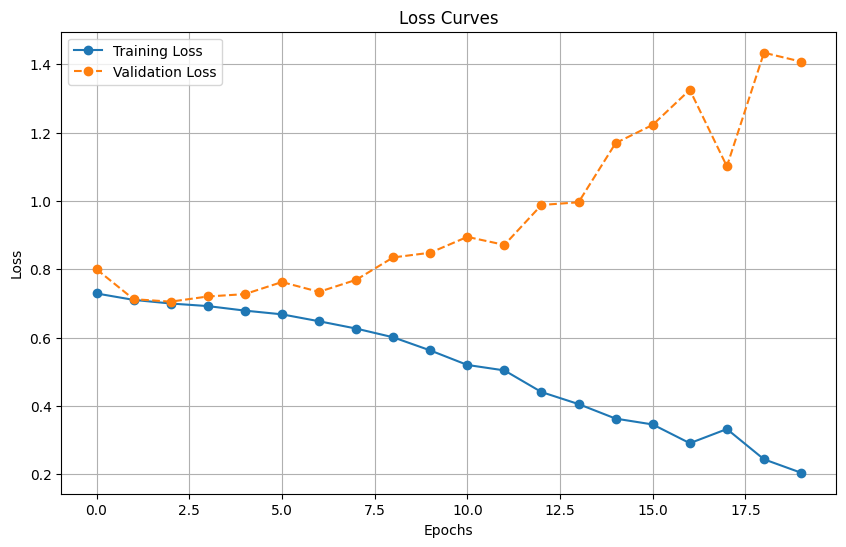

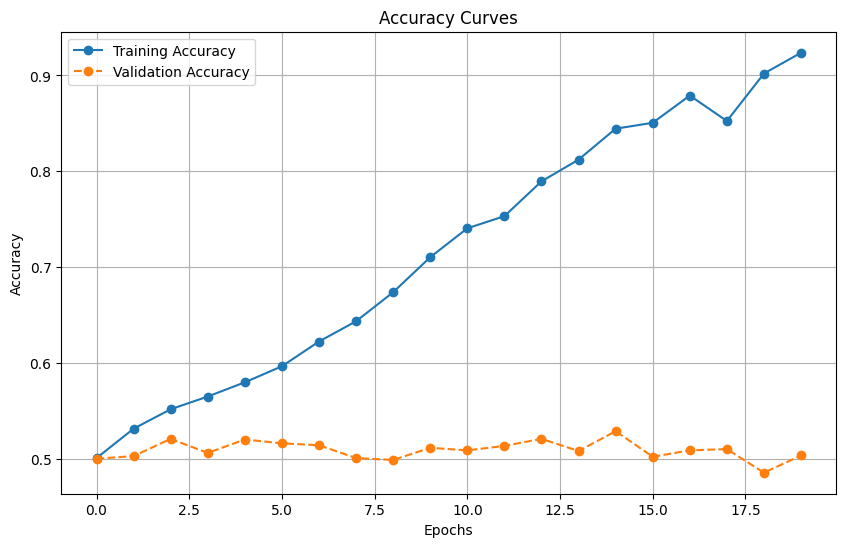

In [318]:
# EXP21
total_samples = 10000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=300)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_size = dataset.num_features 

hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies, times_cpu = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cpu',
    return_times = True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

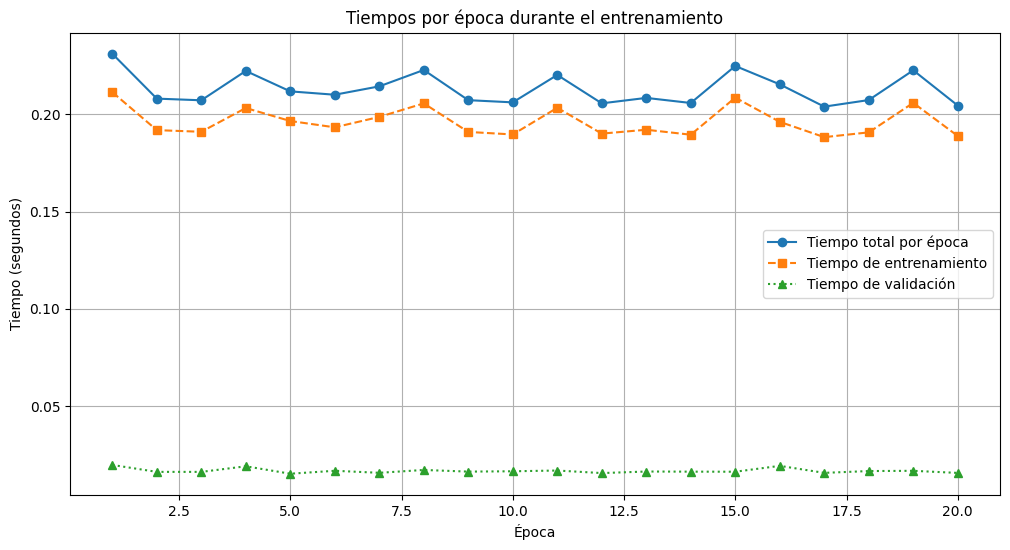

=== Estadísticas de Tiempos CPU ===

Épocas:
  Promedio: 0.2130 s
  Máximo:   0.2312 s
  Mínimo:   0.2040 s

Entrenamiento:
  Promedio: 0.1963 s
  Máximo:   0.2114 s
  Mínimo:   0.1883 s

Validación:
  Promedio: 0.0167 s
  Máximo:   0.0198 s
  Mínimo:   0.0152 s


In [319]:
plot_training_times(times_cpu)
stats = calculate_stats(times_cpu)
print("=== Estadísticas de Tiempos CPU ===")
print(f"\nÉpocas:")
print(f"  Promedio: {stats['epoch']['avg']:.4f} s")
print(f"  Máximo:   {stats['epoch']['max']:.4f} s")
print(f"  Mínimo:   {stats['epoch']['min']:.4f} s")

print(f"\nEntrenamiento:")
print(f"  Promedio: {stats['train']['avg']:.4f} s")
print(f"  Máximo:   {stats['train']['max']:.4f} s")
print(f"  Mínimo:   {stats['train']['min']:.4f} s")

if stats['val']:
    print(f"\nValidación:")
    print(f"  Promedio: {stats['val']['avg']:.4f} s")
    print(f"  Máximo:   {stats['val']['max']:.4f} s")
    print(f"  Mínimo:   {stats['val']['min']:.4f} s")

Model: SimpleFFNN(
  (fc1): Linear(in_features=300, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
Number of parameters: 150701
Epoch:020 Train Acc:89.14% Loss:0.2684 Val Acc:48.27% Loss:1.3647 Time/epoch:0.198s

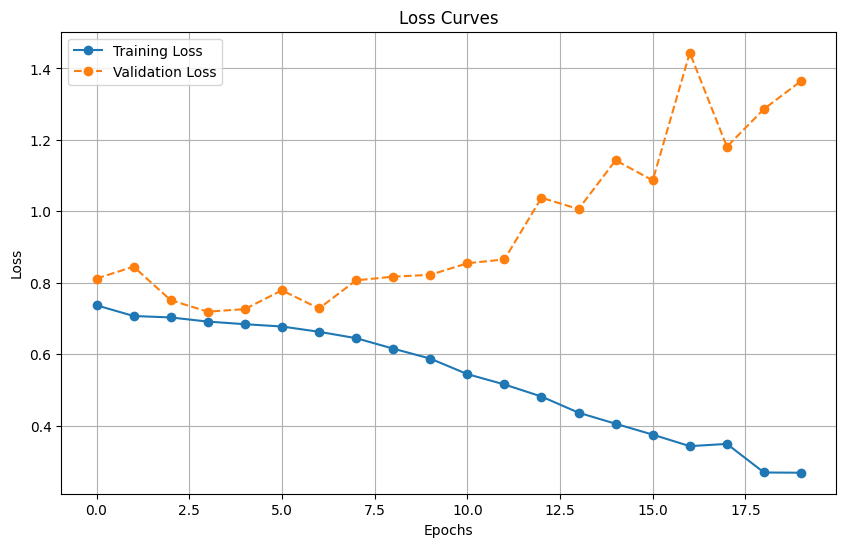

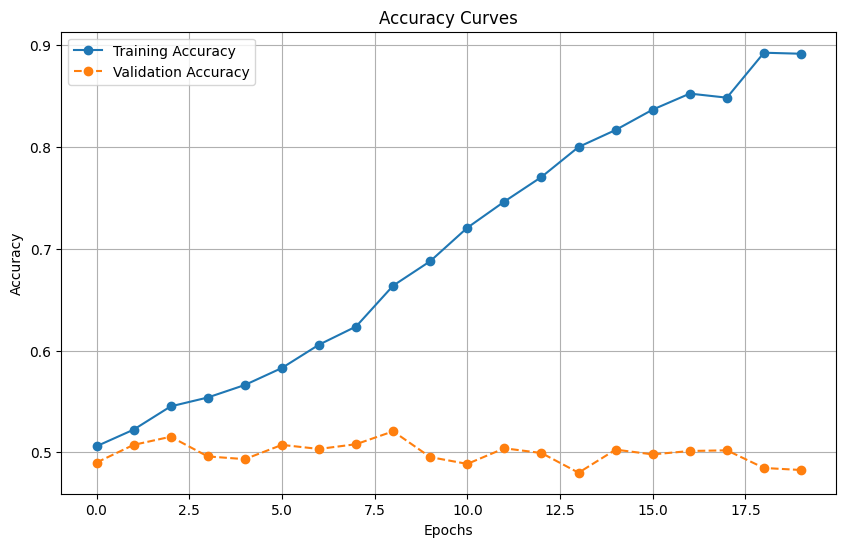

In [321]:
# EXP22
total_samples = 10000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=300)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
input_size = dataset.num_features 

hidden_size1 = 300
hidden_size2 = 200
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies, times_cuda = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    return_times = True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

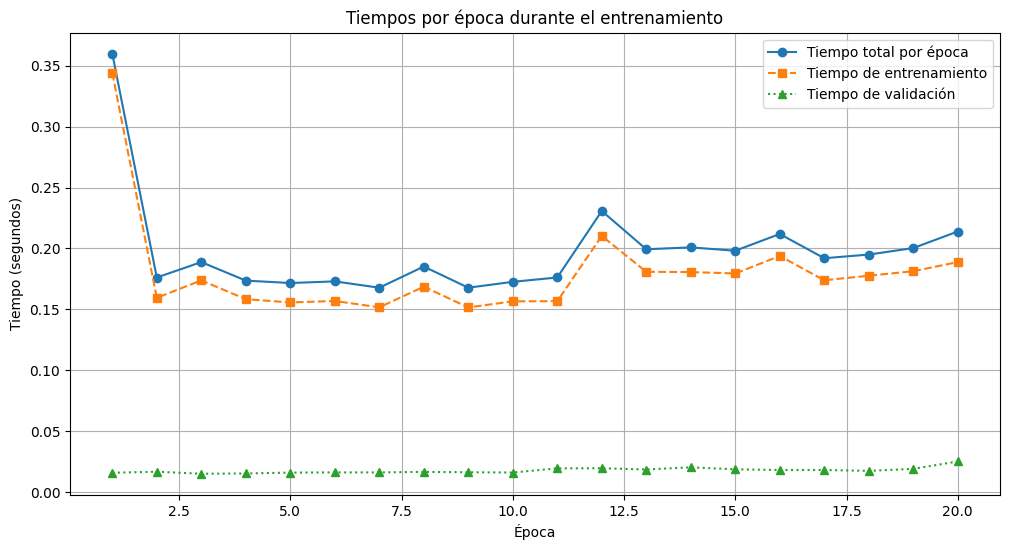

=== Estadísticas de Tiempos GPU ===

Épocas:
  Promedio: 0.1977 s
  Máximo:   0.3598 s
  Mínimo:   0.1677 s

Entrenamiento:
  Promedio: 0.1800 s
  Máximo:   0.3440 s
  Mínimo:   0.1515 s

Validación:
  Promedio: 0.0177 s
  Máximo:   0.0251 s
  Mínimo:   0.0150 s


In [322]:
plot_training_times(times_cuda)
stats = calculate_stats(times_cuda)
print("=== Estadísticas de Tiempos GPU ===")
print(f"\nÉpocas:")
print(f"  Promedio: {stats['epoch']['avg']:.4f} s")
print(f"  Máximo:   {stats['epoch']['max']:.4f} s")
print(f"  Mínimo:   {stats['epoch']['min']:.4f} s")

print(f"\nEntrenamiento:")
print(f"  Promedio: {stats['train']['avg']:.4f} s")
print(f"  Máximo:   {stats['train']['max']:.4f} s")
print(f"  Mínimo:   {stats['train']['min']:.4f} s")

if stats['val']:
    print(f"\nValidación:")
    print(f"  Promedio: {stats['val']['avg']:.4f} s")
    print(f"  Máximo:   {stats['val']['max']:.4f} s")
    print(f"  Mínimo:   {stats['val']['min']:.4f} s")

#### 5.2 Weather Dataset

INIT2: Inicialización del dataset

In [199]:
# INIT2
batch_size = 128


train_loader = DataLoader(
    list(zip(torch.tensor(X_train.values, dtype=torch.float32), 
             torch.tensor(y_train.values[:, None], dtype=torch.float32))), 
    batch_size=batch_size, shuffle=True
)


val_loader = DataLoader(
    list(zip(torch.tensor(X_val.values, dtype=torch.float32), 
             torch.tensor(y_val.values[:, None], dtype=torch.float32))),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(
    list(zip(torch.tensor(X_test.values, dtype=torch.float32), 
             torch.tensor(y_test.values[:, None], dtype=torch.float32))),
    batch_size=batch_size, shuffle=False
)

EXP23: Ocupando el modelo anterior se probará el nuevo conjunto de datos

Model: SimpleFFNN(
  (fc1): Linear(in_features=71, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Number of parameters: 34601
Epoch:020 Train Acc:99.30% Loss:0.0254 Val Acc:99.04% Loss:0.0307 Time/epoch:0.161s

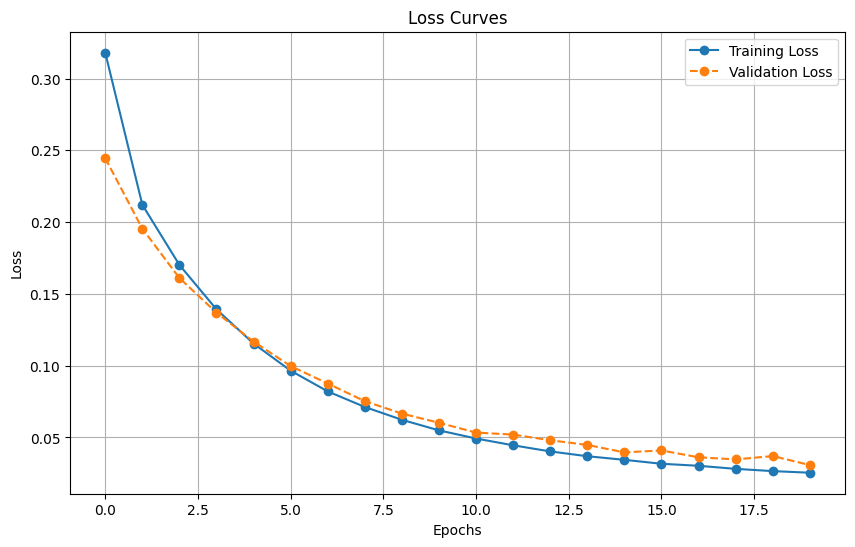

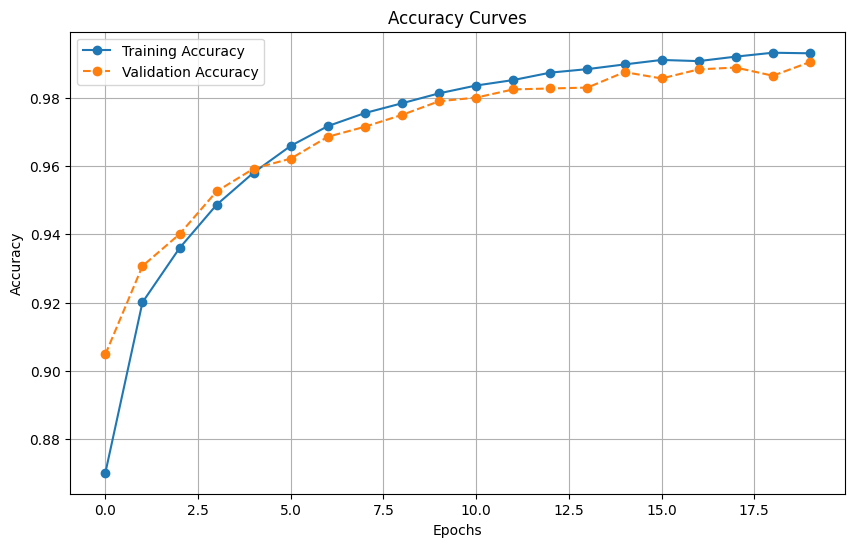

In [205]:
# EXP23
input_size = X_train.shape[1] 
hidden_size1 = 200
hidden_size2 = 100
output_size = 1
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda'
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP23_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP23_acc.png")

EXP24: Sumándole early stopping

Model: SimpleFFNN(
  (fc1): Linear(in_features=71, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Number of parameters: 34601
Epoch:020 Train Acc:99.33% Loss:0.0250 Val Acc:98.91% Loss:0.0356 Time/epoch:0.180s

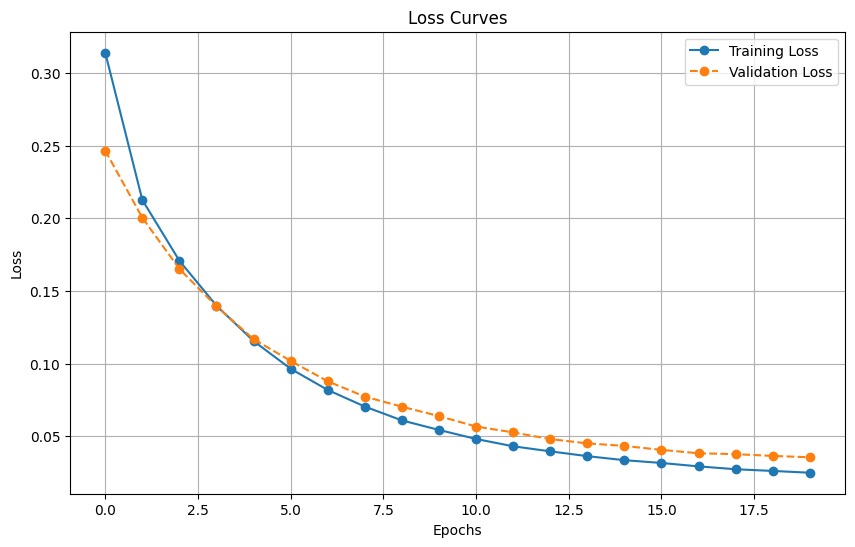

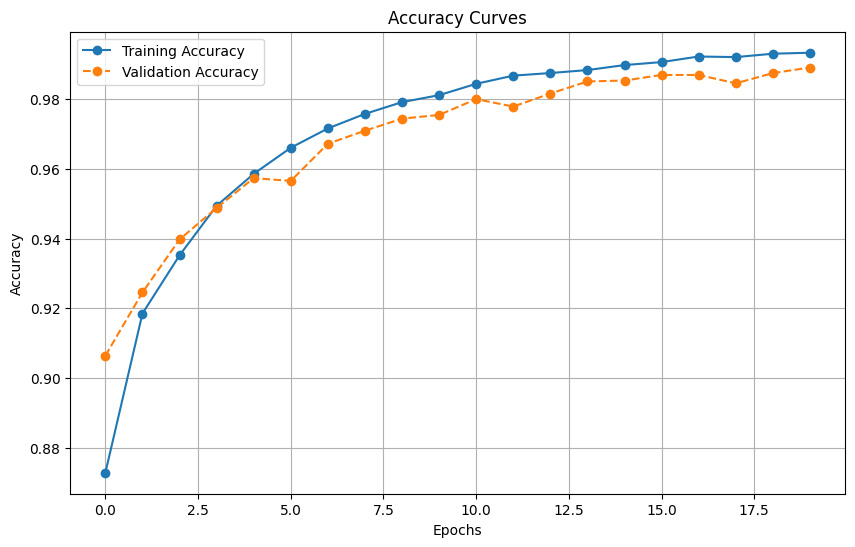

In [206]:
# 

input_size = X_train.shape[1] 
hidden_size1 = 200
hidden_size2 = 100
output_size = 1
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP24_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP24_acc.png")

EXP25: Se prueba init_xavier

Model: SimpleFFNN(
  (fc1): Linear(in_features=71, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Number of parameters: 34601
Epoch:020 Train Acc:99.41% Loss:0.0235 Val Acc:99.07% Loss:0.0285 Time/epoch:0.168s

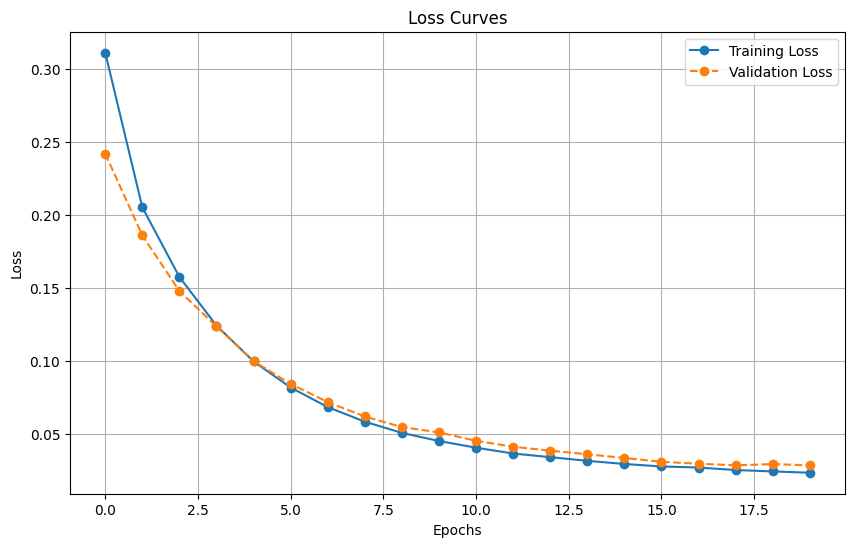

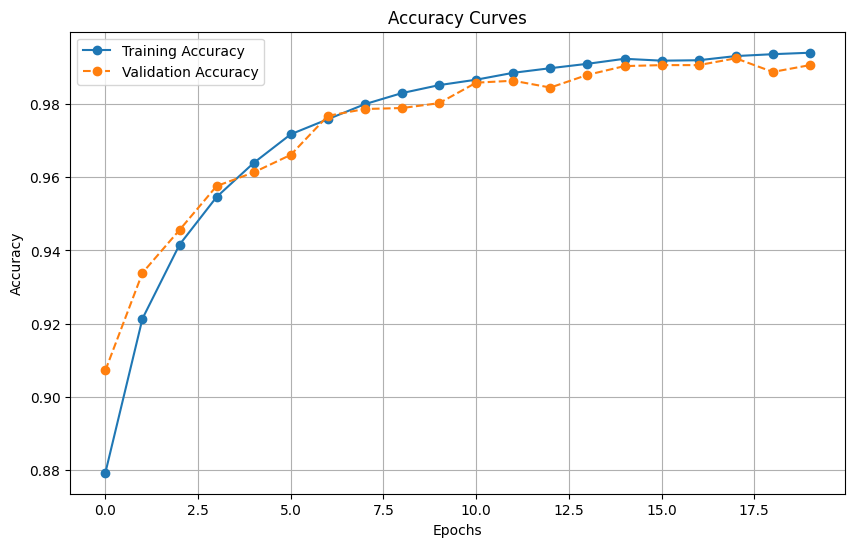

In [207]:
# EXP25
input_size = X_train.shape[1] 
hidden_size1 = 200
hidden_size2 = 100
output_size = 1
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP25_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP25_acc.png")

EXP26: Se modifican cantidad de neurons por capa para saber cómo se comporta el modelo. También se modifica a nesterov optimizer. DropoutFFNN.

Model: DropoutFFNN(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
)
Number of parameters: 781
Epoch:020 Train Acc:99.51% Loss:0.0195 Val Acc:99.33% Loss:0.0219 Time/epoch:0.171s

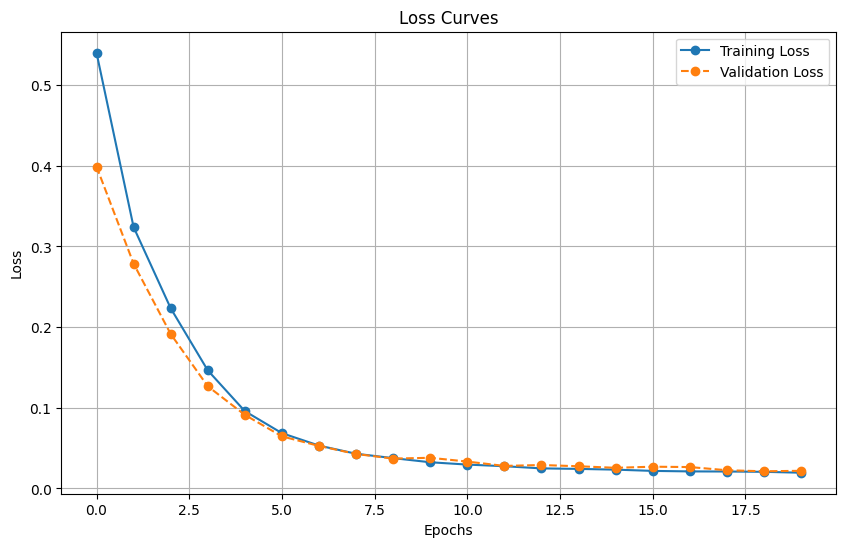

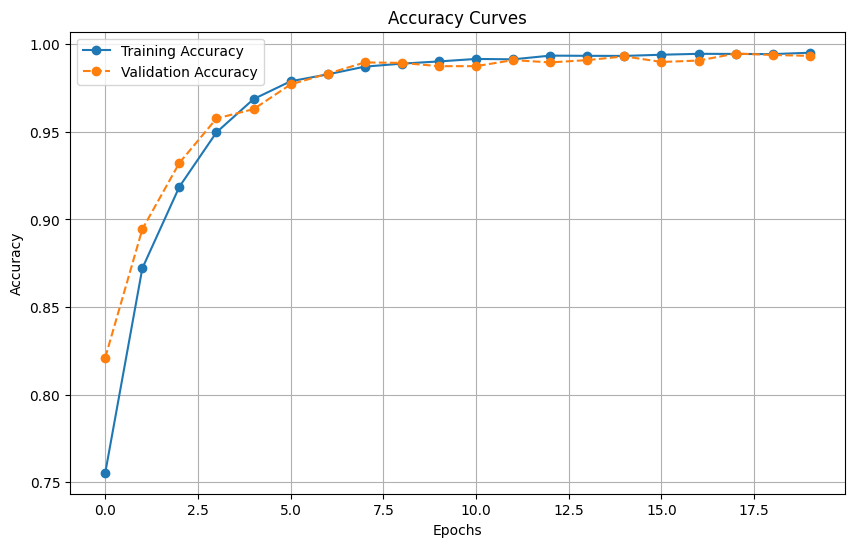

In [208]:
# EXP26
input_size = X_train.shape[1] 
hidden_size1 = 10
hidden_size2 = 5
output_size = 1
model = DropoutFFNN(input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.65)
optimizer = get_sgd_nesterov_optimizer(model, lr=0.009, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP26_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP26_acc.png")

Model: BatchNormFFNN(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 811
Epoch:018 Train Acc:98.94% Loss:0.0242 Val Acc:98.80% Loss:0.0290 Time/epoch:0.188s
Early stopping triggered after 19 epochs!


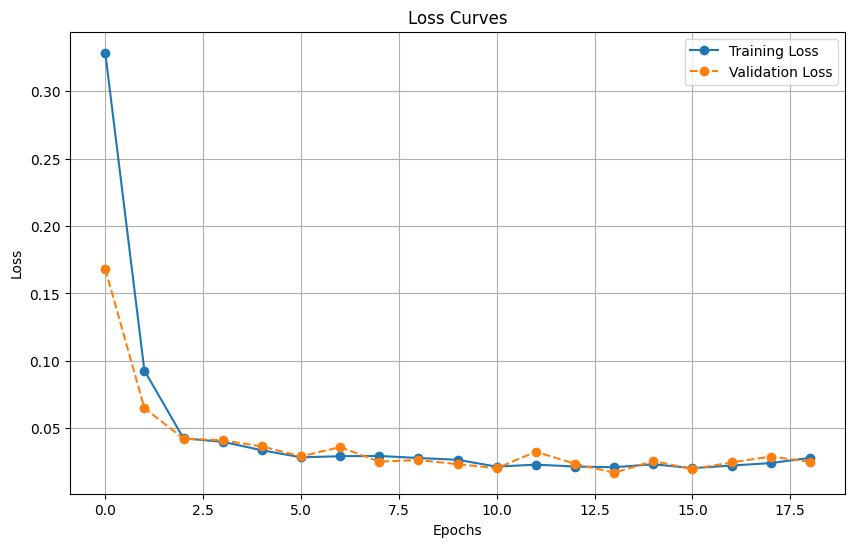

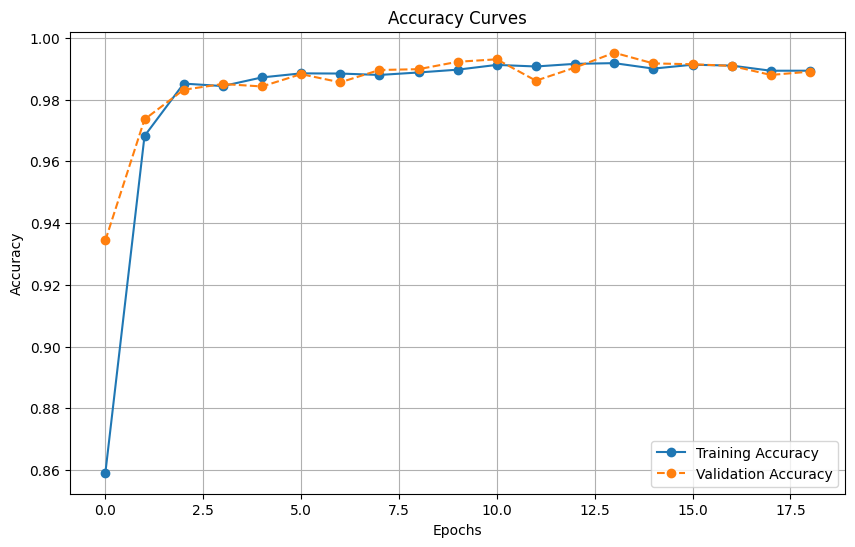

In [212]:
# EXP27
input_size = X_train.shape[1] 
hidden_size1 = 10
hidden_size2 = 5
output_size = 1
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_nesterov_optimizer(model, lr=0.009, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    reports_every=1,
    device='cuda',
    use_early_stopping=True
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP27_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP27_acc.png")

Evaluando modelo de EXP26

In [210]:
# EXP26-1
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0244, Test Accuracy: 99.12%


#### 5.2.1 Probando con ensamble

In [245]:
from torch.utils.data import TensorDataset

train_weather_ds = TensorDataset(
    torch.tensor(X_train.values, dtype=torch.float32),
    torch.tensor(y_train.values[:, None], dtype=torch.float32)
)

In [248]:
def create_optimizer(model):
    return get_sgd_nesterov_optimizer(model, lr=0.009, weight_decay=0.001)

In [249]:
# EXP26-ENS
input_size = X_train.shape[1] 
hidden_size1 = 10
hidden_size2 = 5
output_size = 1
n_models = 8
epochs = 20
ensemble_models, train_losses, val_losses, train_acc, val_acc = train_ensemble(
    model_fn=lambda: DropoutFFNN(input_size, hidden_size1, hidden_size2, output_size),
    optimizer_fn=create_optimizer,
    train_dataset=train_weather_ds,
    val_loader=val_loader,
    n_models=n_models,       
    epochs=epochs,   
    binary=True,
    use_early_stopping = True
)


Training model 1/8...
Model: DropoutFFNN(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 781
Epoch:010 Train Acc:98.82% Loss:0.0305 Val Acc:97.41% Loss:0.0687 Time/epoch:0.681s
Early stopping triggered after 11 epochs!

Training model 2/8...
Model: DropoutFFNN(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 781
Epoch:012 Train Acc:98.97% Loss:0.0270 Val Acc:98.05% Loss:0.0558 Time/epoch:0.725s
Early stopping triggered after 13 epochs!

Training model 3/8...
Model: DropoutFFNN(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (f

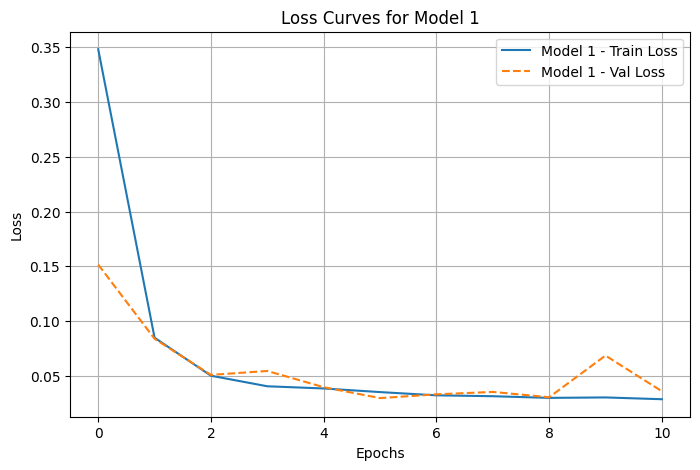

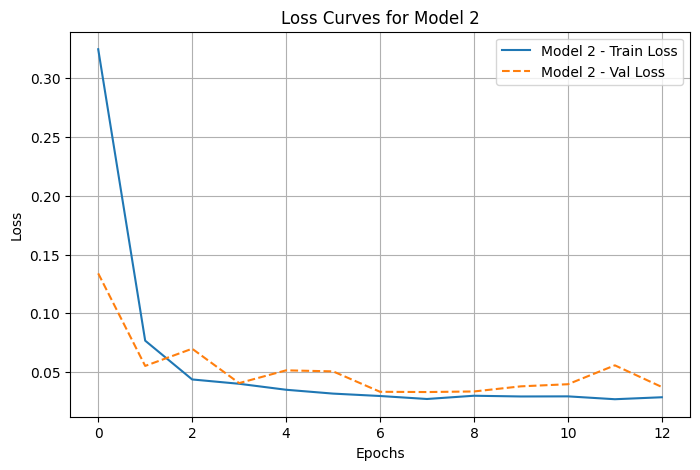

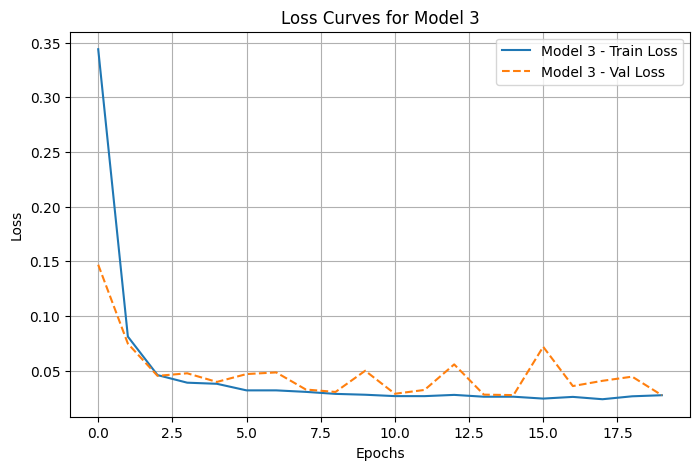

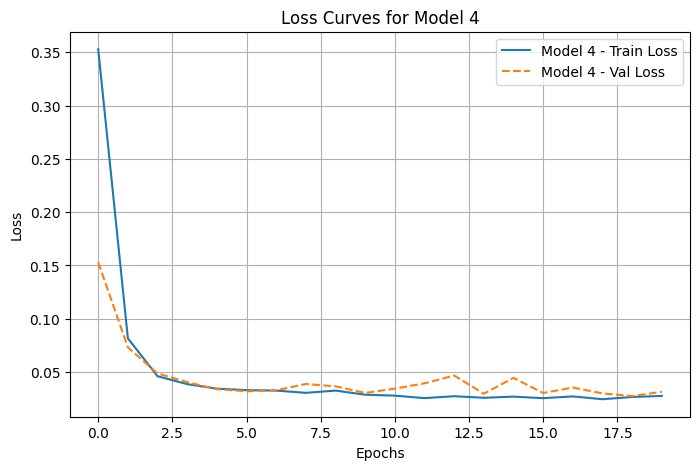

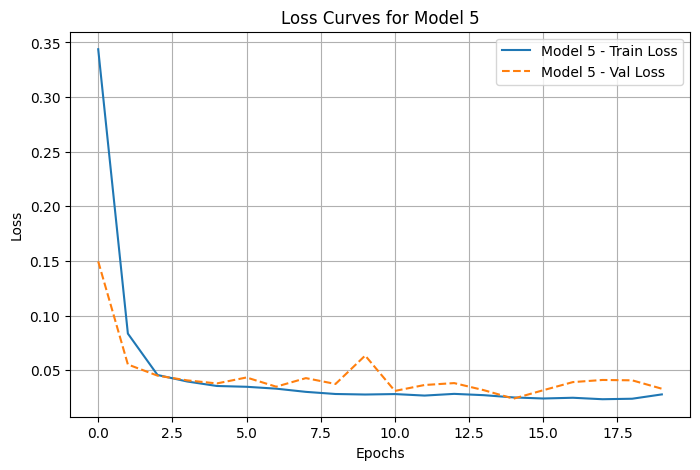

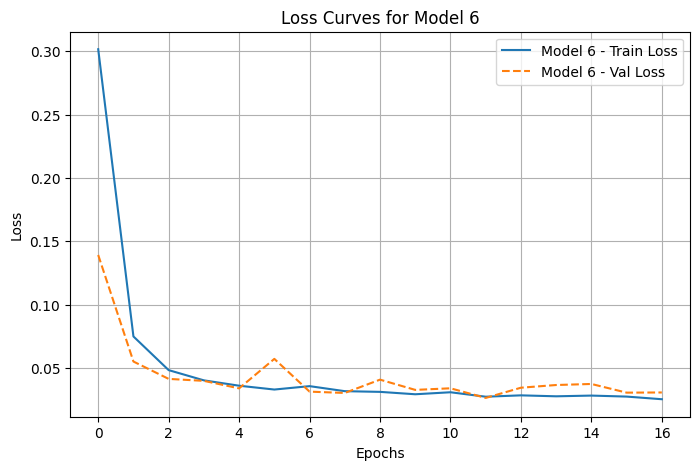

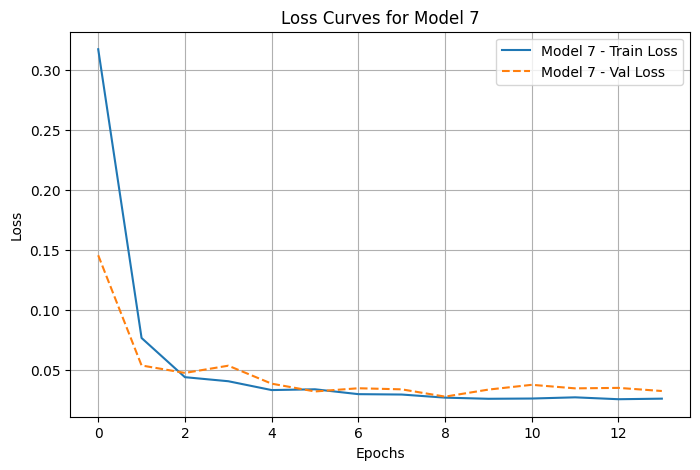

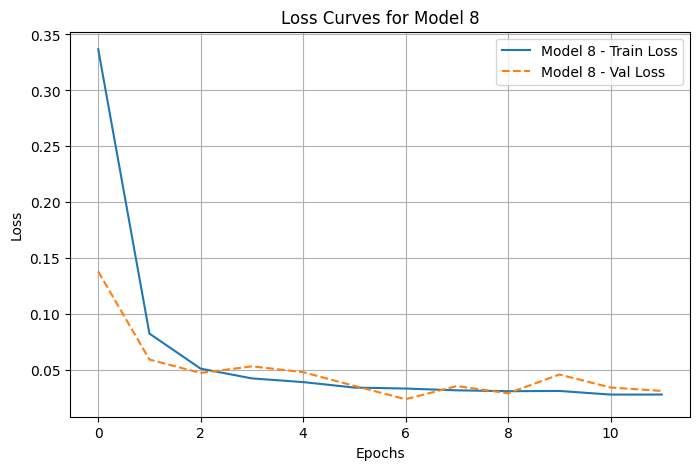

In [250]:
#EXP26-ENS
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label=f"Model {i+1} - Train Loss")
    plt.plot(val_loss, label=f"Model {i+1} - Val Loss", linestyle="--")
    plt.title(f"Loss Curves for Model {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    file_name = f"images/EXP26-ENS_loss_{i+1}.png"
    plt.savefig(file_name) 
    
    plt.show()
    plt.close()  

In [251]:
final_train_losses = [loss[-1] for loss in train_losses]
final_val_losses = [loss[-1] for loss in val_losses]

for i, (train_loss, val_loss) in enumerate(zip(final_train_losses, final_val_losses)):
    print(f"Model {i+1} - Final Train Loss: {train_loss:.4f}, Final Val Loss: {val_loss:.4f}")


Model 1 - Final Train Loss: 0.0289, Final Val Loss: 0.0361
Model 2 - Final Train Loss: 0.0287, Final Val Loss: 0.0374
Model 3 - Final Train Loss: 0.0275, Final Val Loss: 0.0275
Model 4 - Final Train Loss: 0.0276, Final Val Loss: 0.0315
Model 5 - Final Train Loss: 0.0278, Final Val Loss: 0.0330
Model 6 - Final Train Loss: 0.0256, Final Val Loss: 0.0309
Model 7 - Final Train Loss: 0.0263, Final Val Loss: 0.0327
Model 8 - Final Train Loss: 0.0281, Final Val Loss: 0.0313


In [252]:
#EXP26-ENS
accuracy, test_loss = evaluate_ensemble(
    ensemble_models=ensemble_models,
    test_loader=test_loader,
    device='cuda',
    binary=True
)

print(f"Ensemble Accuracy: {accuracy * 100:.2f}%")
print(f"Ensemble Test Loss: {test_loss:.4f}")

Predictions Binary Shape: (3750,)
True Labels Shape: (3750,)
Ensemble Accuracy: 99.39%
Ensemble Test Loss: 0.0252


#### 5.3 MNIST Digit Number Dataset

#### 5.3.1 Obtención del dataset y preprocesamiento

In [253]:
# INIT3
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), 
    transforms.Lambda(lambda x: x.view(-1)) 
])
train_dataset_mnist = datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)
train_size_mnist = int(len(train_dataset_mnist) * 0.8) 
val_size_mnist = len(train_dataset_mnist) - train_size_mnist 
train_mnist, val_mnist = random_split(train_dataset_mnist, [train_size_mnist, val_size_mnist])

EXP28: modelo simple de ffnn para mnist batch size 64

Tamaño de entrenamiento: 48000
Tamaño de validación: 12000
Tamaño de test: 10000
Model: SimpleFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Number of parameters: 178110
Epoch:020 Train Acc:96.11% Loss:1.5019 Val Acc:95.58% Loss:1.5084 Time/epoch:7.234s

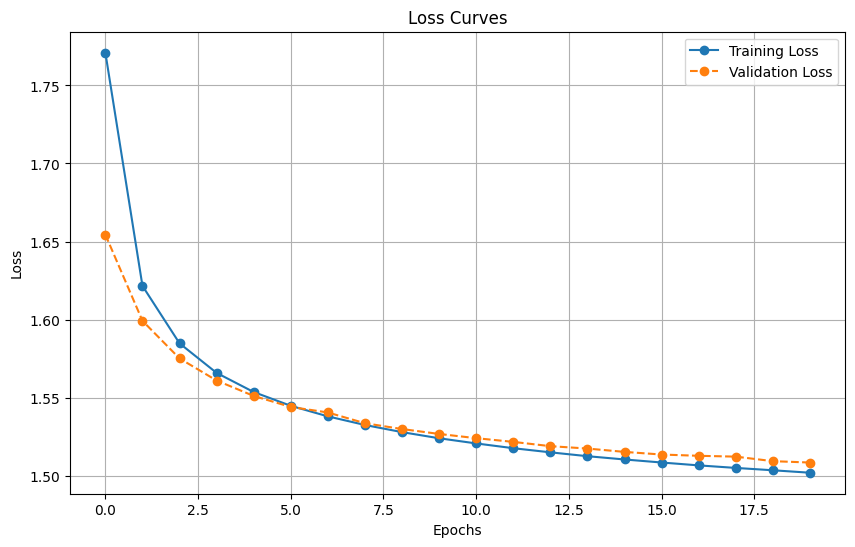

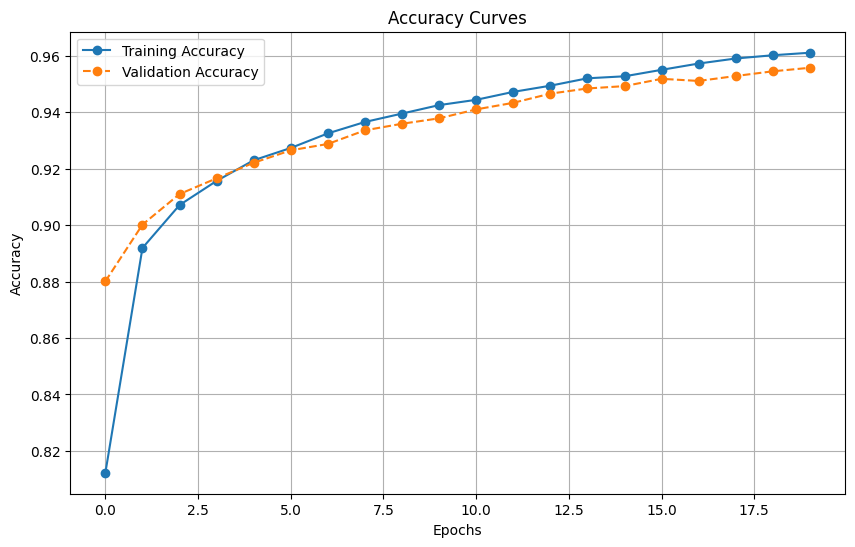

In [221]:
# EXP28
batch_size = 64

train_loader_mnist = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)  
val_loader_mnist = DataLoader(val_mnist, batch_size=batch_size, shuffle=False)   
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=64, shuffle=False)

print(f'Tamaño de entrenamiento: {len(train_mnist)}')
print(f'Tamaño de validación: {len(val_mnist)}')
print(f'Tamaño de test: {len(test_dataset_mnist)}')

input_size = 28 * 28
hidden_size1 = 200
hidden_size2 = 100
output_size = 10
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP28_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP28_acc.png")
beep(sound=1)

EXP29: modelo simple de ffnn para mnist batch size 128

Tamaño de entrenamiento: 48000
Tamaño de validación: 12000
Tamaño de test: 10000
Model: SimpleFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Number of parameters: 178110
Epoch:020 Train Acc:94.49% Loss:1.5215 Val Acc:94.25% Loss:1.5246 Time/epoch:4.571s

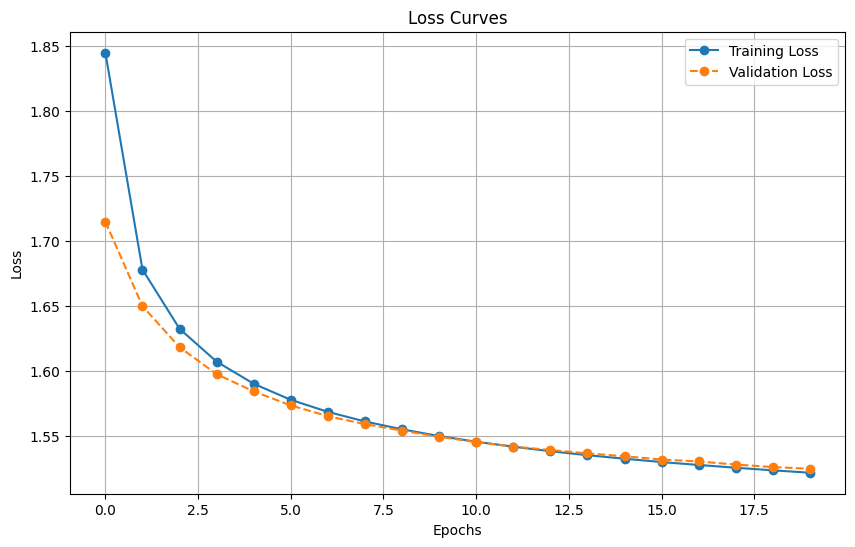

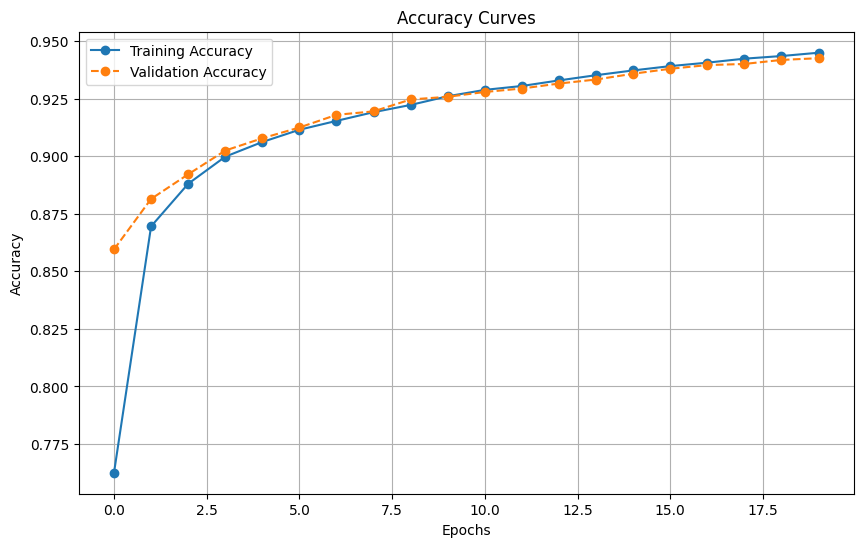

In [223]:
# EXP29

batch_size = 128

train_loader_mnist = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)  
val_loader_mnist = DataLoader(val_mnist, batch_size=batch_size, shuffle=False)   
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=64, shuffle=False)

print(f'Tamaño de entrenamiento: {len(train_mnist)}')
print(f'Tamaño de validación: {len(val_mnist)}')
print(f'Tamaño de test: {len(test_dataset_mnist)}')


input_size = 28 * 28
hidden_size1 = 200
hidden_size2 = 100
output_size = 10
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP29_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP29_acc.png")
beep(sound=1)

In [254]:
batch_size = 64 # 1073741824/(1788810*8) = 75

train_loader_mnist = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)  
val_loader_mnist = DataLoader(val_mnist, batch_size=batch_size, shuffle=False)   
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=64, shuffle=False)

EXP30: Cambio en la inicialización he

Model: SimpleFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Number of parameters: 178110
Epoch:020 Train Acc:96.43% Loss:1.5002 Val Acc:95.39% Loss:1.5090 Time/epoch:5.777s

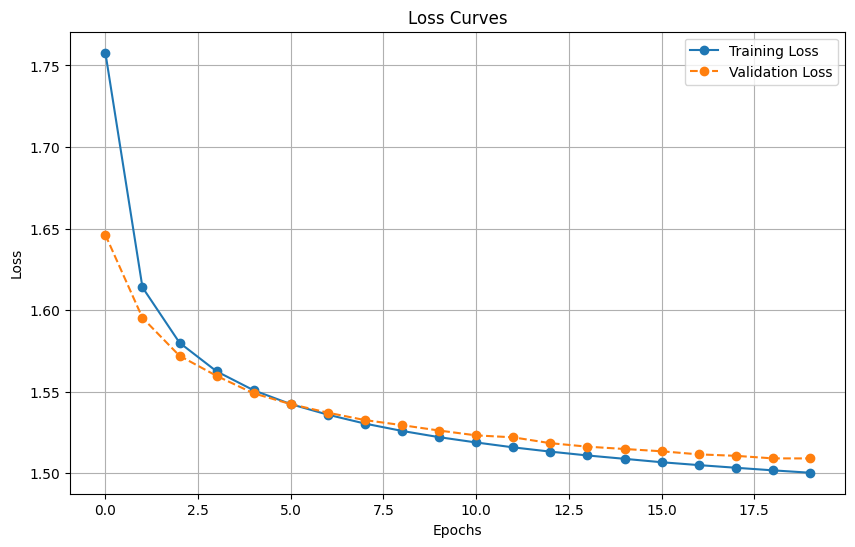

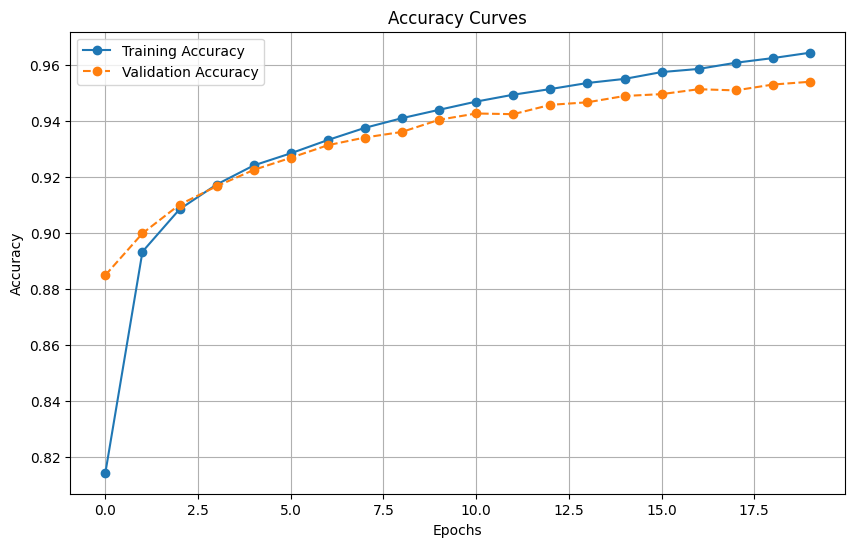

In [255]:
# EXP30
input_size = 28 * 28
hidden_size1 = 200
hidden_size2 = 100
output_size = 10
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.05)
init_he(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP30_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP30_acc.png")
beep(sound=1)

EXP31: BatchNorm para Mnist

Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 178710
Epoch:020 Train Acc:97.31% Loss:1.4980 Val Acc:96.05% Loss:1.5087 Time/epoch:5.907s

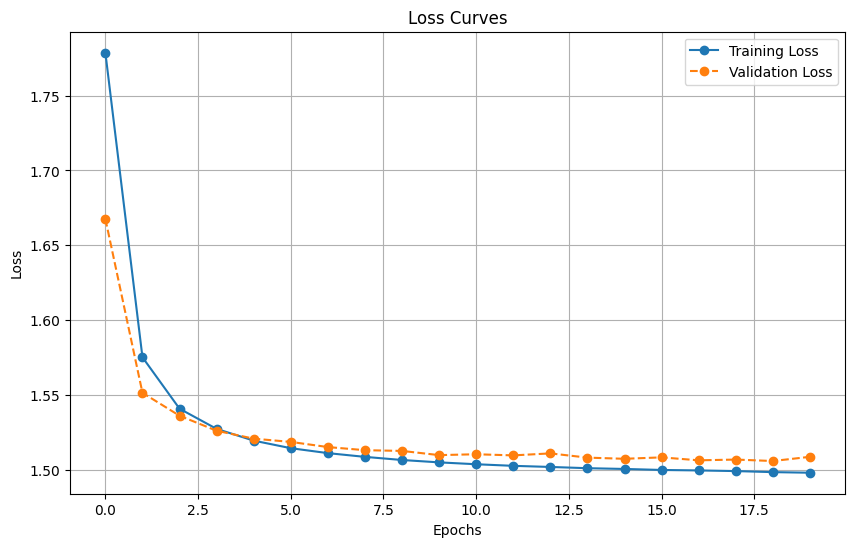

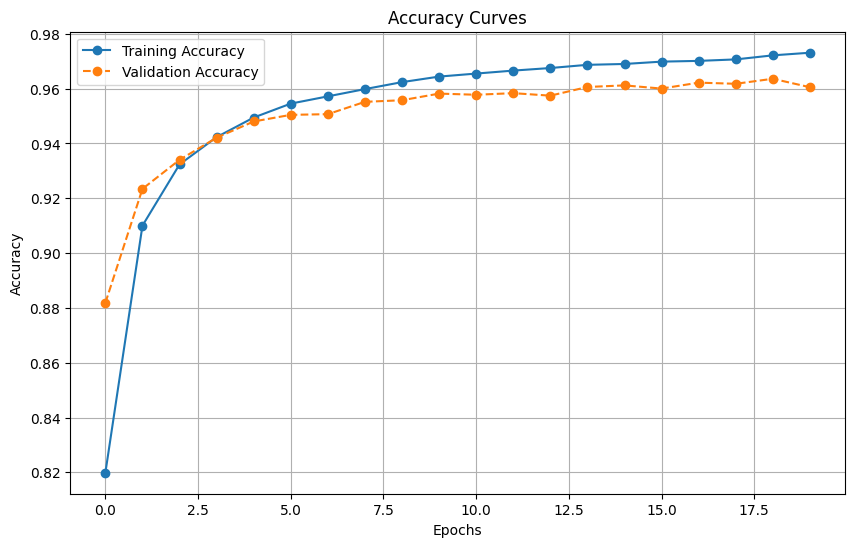

In [256]:
# EXP31
input_size = 28*28
hidden_size1 = 200
hidden_size2 = 100
output_size = 10
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP31_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP31_acc.png")
beep(sound=1)

EXP32: BatchNorm para Mnist con menos neuronas en las capas

Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 84360
Epoch:020 Train Acc:97.07% Loss:1.4994 Val Acc:95.97% Loss:1.5076 Time/epoch:5.803s

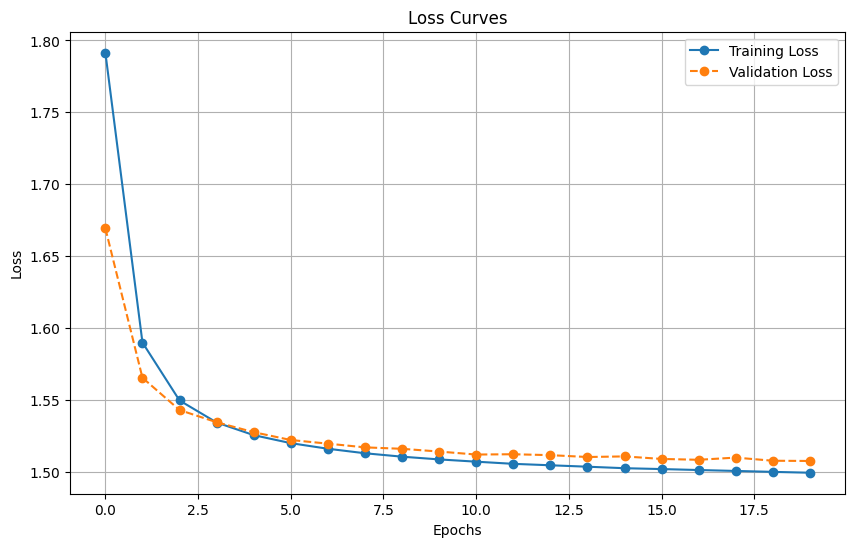

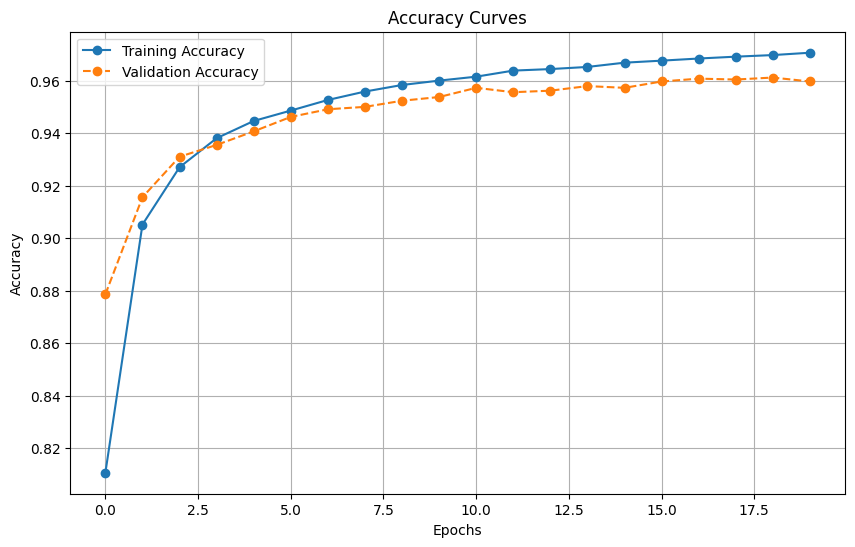

In [257]:
# EXP32
input_size = 28*28
hidden_size1 = 100
hidden_size2 = 50
output_size = 10
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP32_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP32_acc.png")
beep(sound=1)

EXP33: Prueba de dropout

Model: DropoutFFNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 84060
Epoch:020 Train Acc:95.21% Loss:1.5271 Val Acc:94.60% Loss:1.5317 Time/epoch:6.046s

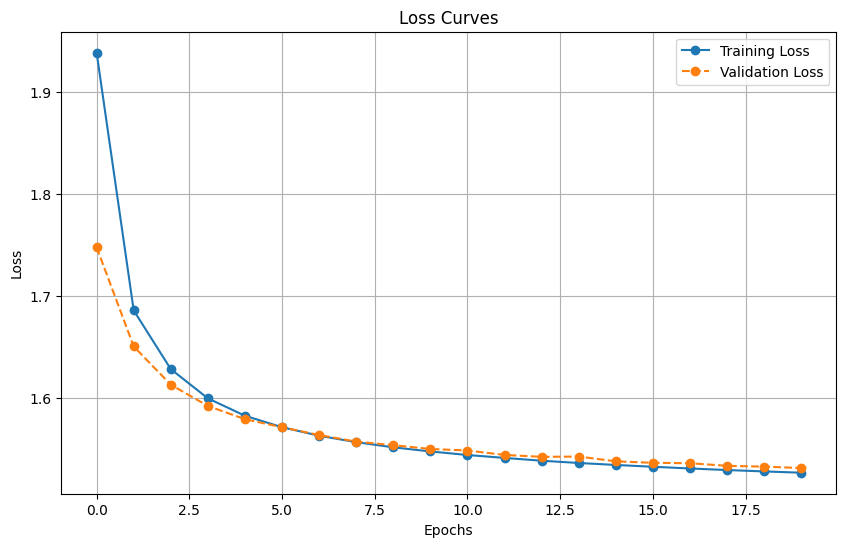

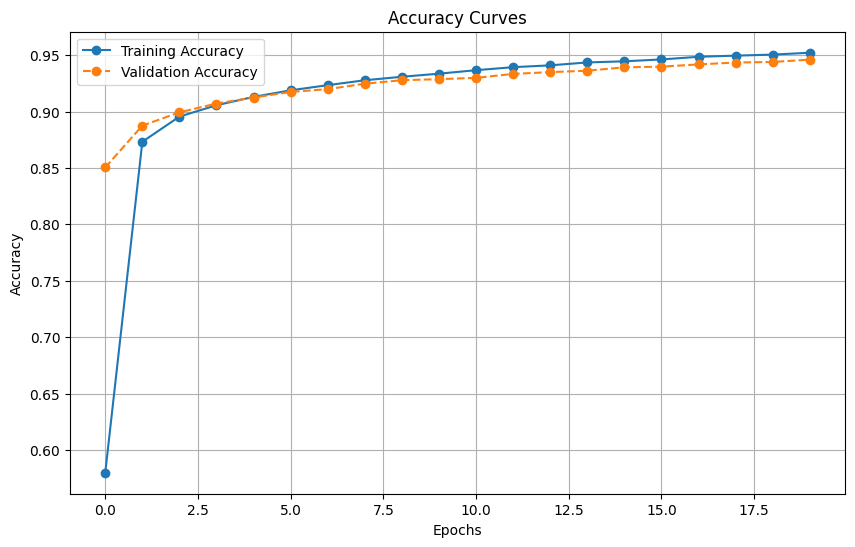

In [258]:
# EXP33
input_size = 28*28
hidden_size1 = 100
hidden_size2 = 50
output_size = 10
model = DropoutFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP33_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP33_acc.png")
beep(sound=1)

EXP34: Viendo batch norm dropout ffnn

Model: BatchNormDropoutFFNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters: 84360
Epoch:020 Train Acc:94.54% Loss:1.5377 Val Acc:94.02% Loss:1.5415 Time/epoch:6.555s

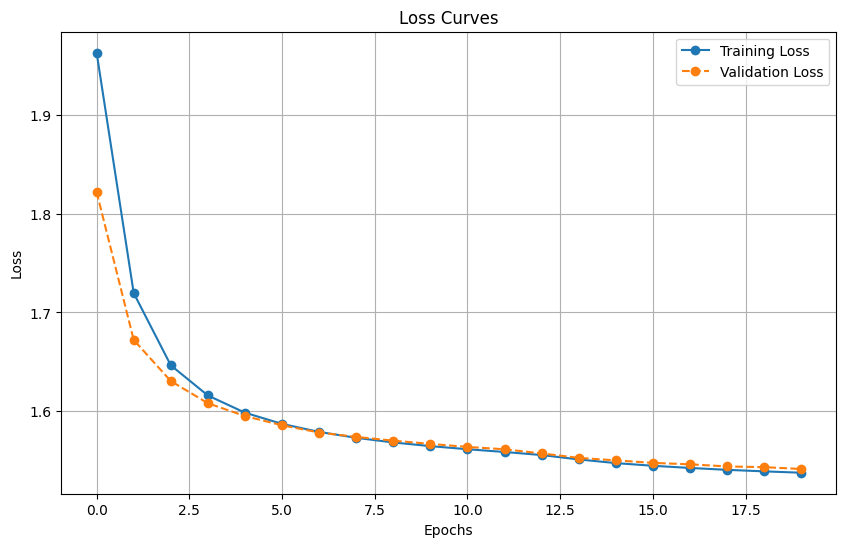

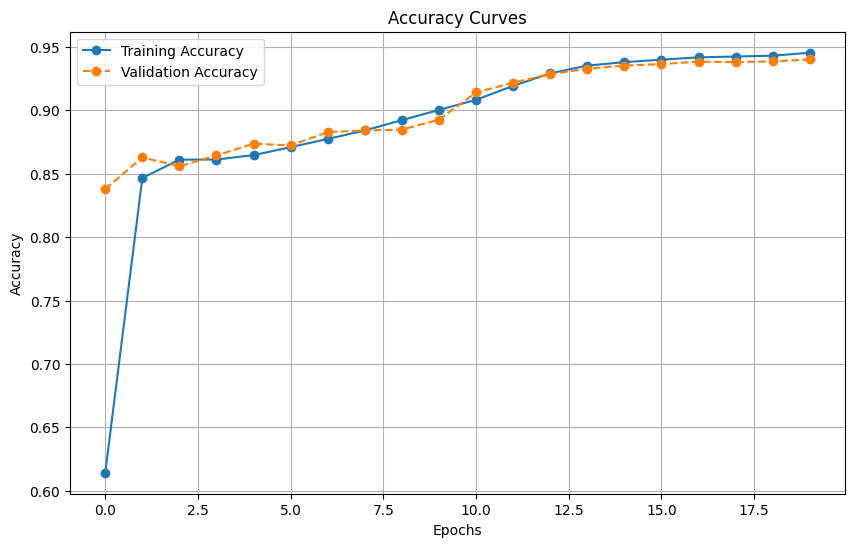

In [259]:
#EXP34
input_size = 28*28
hidden_size1 = 100
hidden_size2 = 50
output_size = 10
model = BatchNormDropoutFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP34_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP34_acc.png")
beep(sound=1)

EXP35: Modificando a nesterov optimizer con menos neuroonas por capa

Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 102430
Epoch:020 Train Acc:96.20% Loss:1.5017 Val Acc:95.37% Loss:1.5079 Time/epoch:6.149s

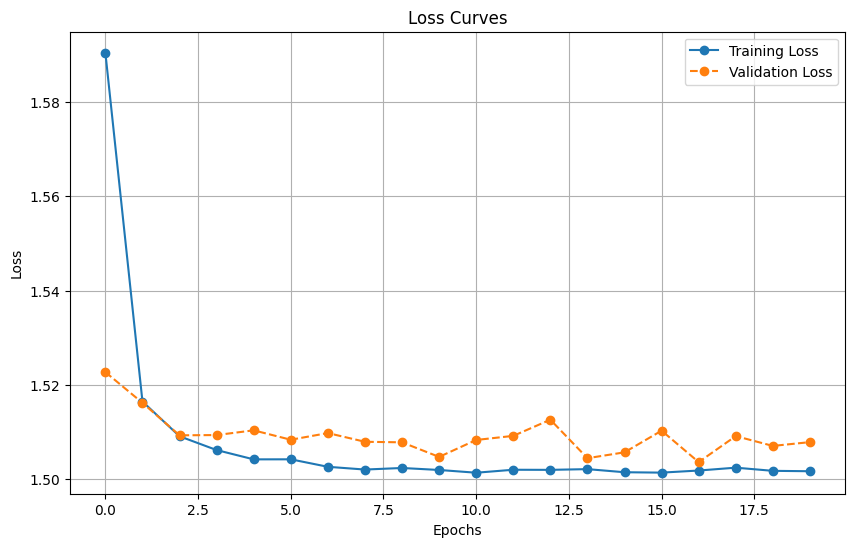

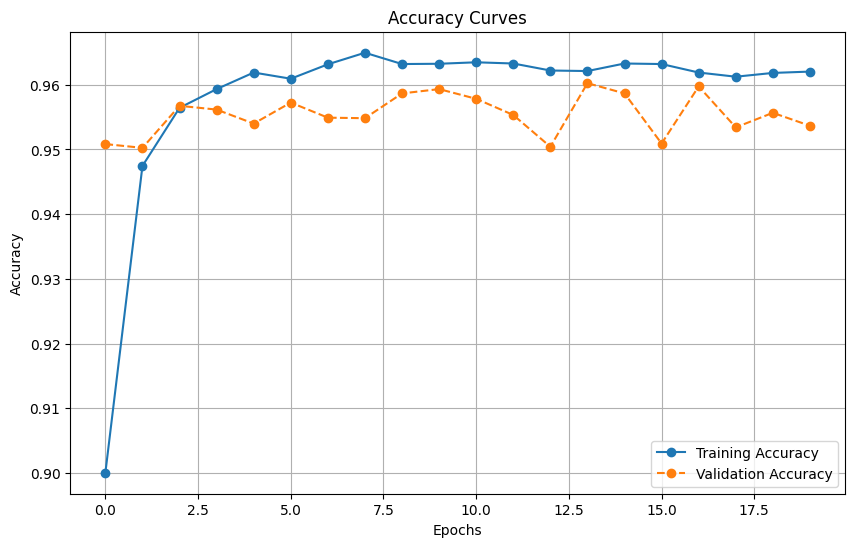

In [260]:
#EXP35
input_size = 28*28
hidden_size1 = 120
hidden_size2 = 60
output_size = 10
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_nesterov_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP35_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP35_acc.png")
beep(sound=1)

EXP36: Lo mismo que EXP31 pero con menos neurons

Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 102430
Epoch:020 Train Acc:96.94% Loss:1.5002 Val Acc:95.88% Loss:1.5093 Time/epoch:6.339s

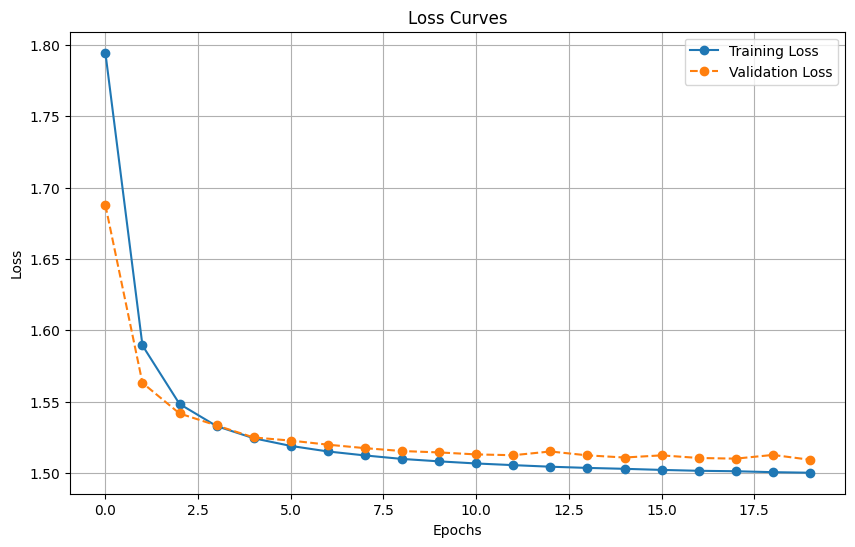

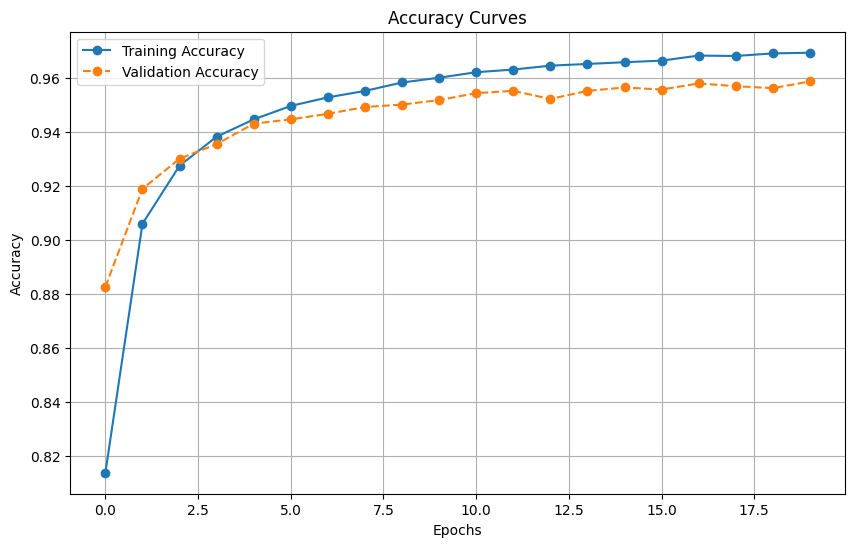

In [261]:
#EXP36
input_size = 28*28
hidden_size1 = 120
hidden_size2 = 60
output_size = 10
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.05, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=20,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP36_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP36_acc.png")
beep(sound=1)

Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 178710
Epoch:025 Train Acc:97.25% Loss:1.4975 Val Acc:96.08% Loss:1.5070 Time/epoch:5.907s

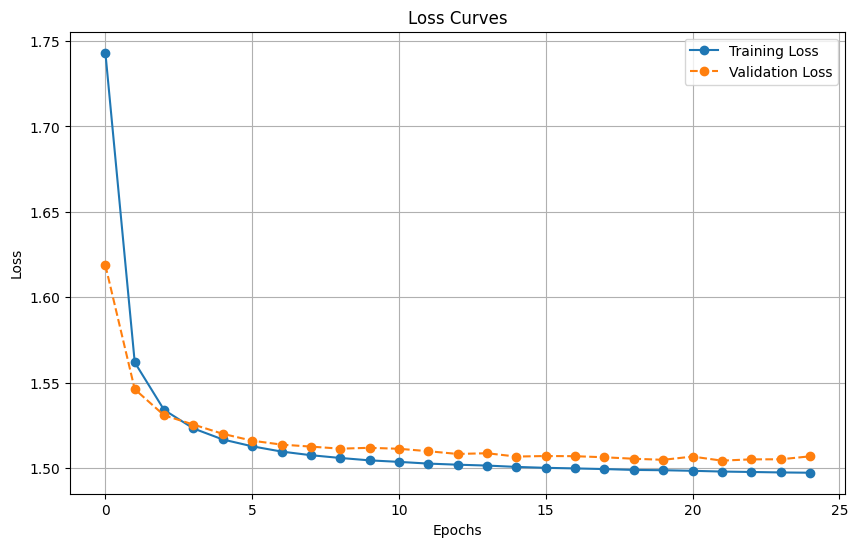

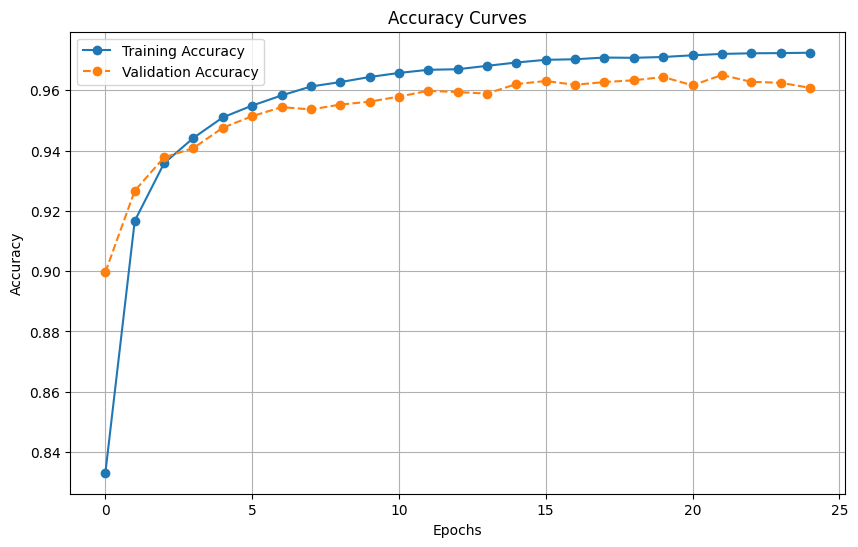

In [262]:
# EXP37
input_size = 28*28
hidden_size1 = 200
hidden_size2 = 100
output_size = 10
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.065, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=25,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP37_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP37_acc.png")
beep(sound=1)

EXP38: Lo mismo que EXP33 pero con más neurons

Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=10, bias=True)
  (bn1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 656110
Epoch:030 Train Acc:97.63% Loss:1.4942 Val Acc:96.67% Loss:1.5010 Time/epoch:5.917s

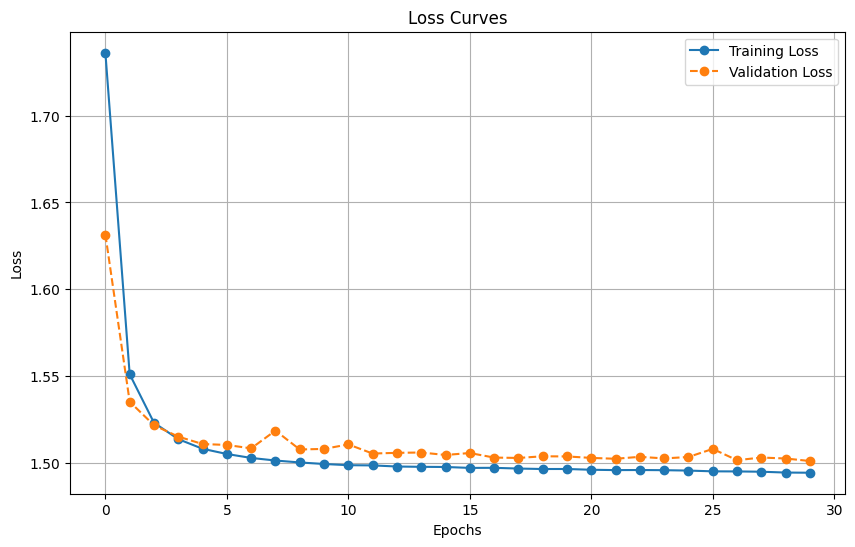

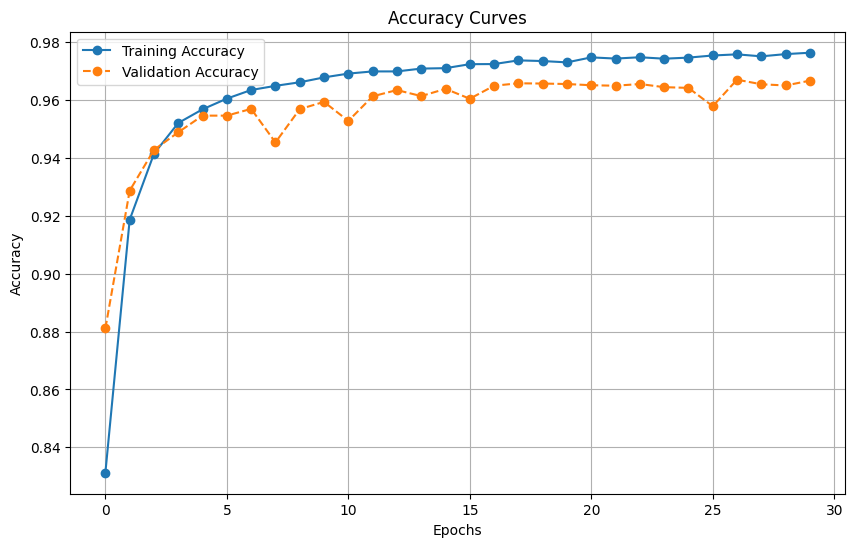

In [263]:
# EXP38
input_size = 28*28
hidden_size1 = 600
hidden_size2 = 300
output_size = 10
model = BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = get_sgd_optimizer(model, lr=0.065, weight_decay=0.001)
init_xavier(model)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader_mnist,
    val_loader=val_loader_mnist,
    epochs=30,
    reports_every=1,
    device='cuda',
    binary=False,
    use_early_stopping=True,
    patience=5
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves", save_path="images/EXP38_loss.png")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves", save_path="images/EXP38_acc.png")
beep(sound=1)

In [264]:
#EXP38-1
avg_loss, test_accuracy = evaluate_model(model, test_loader_mnist, binary=False)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}%")
print(f"Pérdida en el conjunto de prueba: {avg_loss:.2f}%")

BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=10, bias=True)
  (bn1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Precisión en el conjunto de prueba: 96.88%
Pérdida en el conjunto de prueba: 1.50%


EXP38: Probar con Modelo Ensamblador

In [266]:
def create_optimizer_mnist(model):
    return get_sgd_optimizer(model, lr=0.065, weight_decay=0.001)

In [267]:
# EXP37-ENS
input_size = 28*28
hidden_size1 = 200
hidden_size2 = 100
output_size = 10
n_models = 8
epochs = 20
ensemble_models, train_losses, val_losses, train_acc, val_acc = train_ensemble(
    model_fn=lambda: BatchNormFFNN(input_size, hidden_size1, hidden_size2, output_size),
    optimizer_fn=create_optimizer_mnist,
    train_dataset=train_dataset_mnist,
    val_loader=val_loader_mnist,
    n_models=n_models,       
    epochs=epochs,   
    binary=False,
    use_early_stopping = False
)
beep(sound=1)


Training model 1/8...
Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 178710
Epoch:020 Train Acc:98.19% Loss:1.4838 Val Acc:97.45% Loss:1.4910 Time/epoch:9.606s
Training model 2/8...
Model: BatchNormFFNN(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters: 178710
Epoch:020 Train Acc:98.05% Loss:1.4

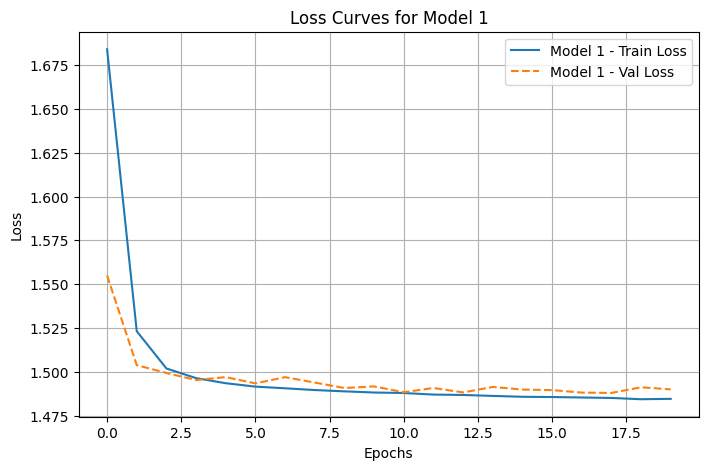

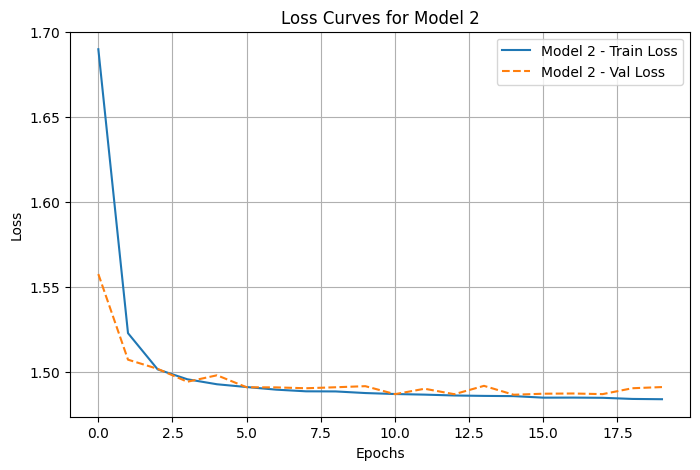

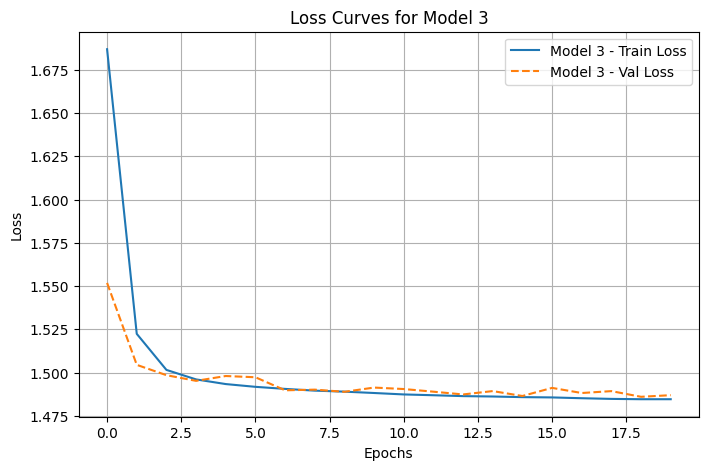

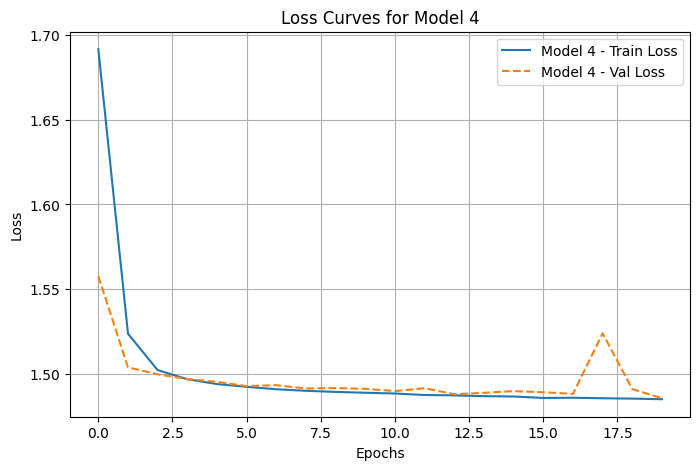

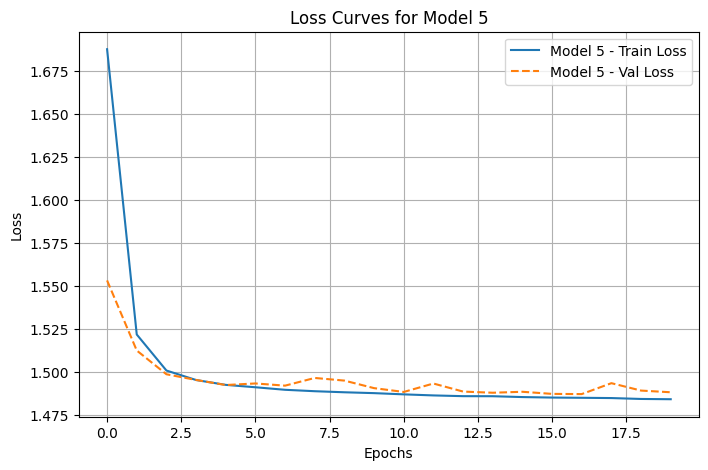

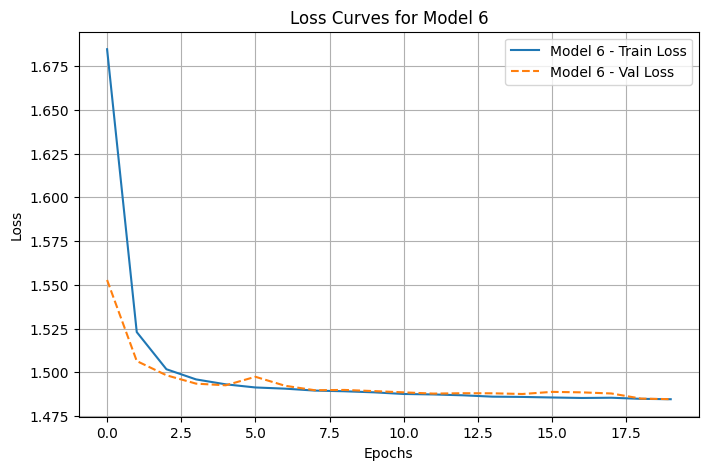

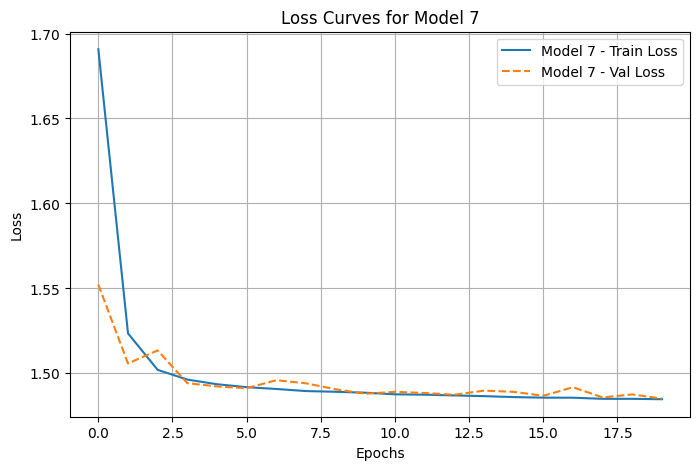

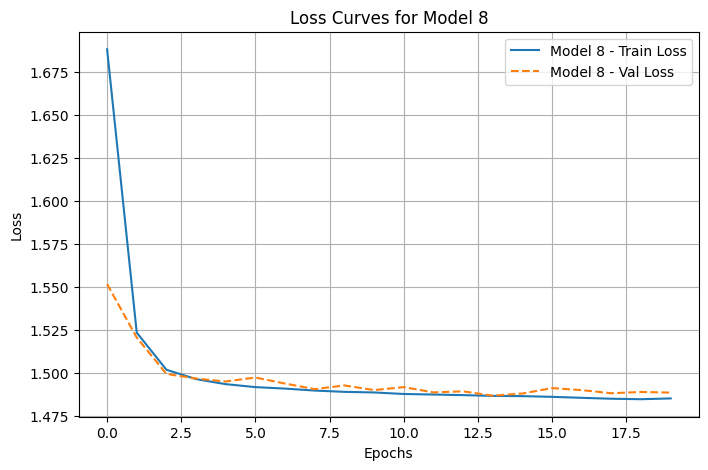

In [239]:
# EXP38-ENS
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label=f"Model {i+1} - Train Loss")
    plt.plot(val_loss, label=f"Model {i+1} - Val Loss", linestyle="--")
    plt.title(f"Loss Curves for Model {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    file_name = f"images/EXP38-ENS_loss_{i+1}.png"
    plt.savefig(file_name) 
    
    plt.show()
    plt.close()  

In [150]:
final_train_losses = [loss[-1] for loss in train_losses]
final_val_losses = [loss[-1] for loss in val_losses]

for i, (train_loss, val_loss) in enumerate(zip(final_train_losses, final_val_losses)):
    print(f"Model {i+1} - Final Train Loss: {train_loss:.4f}, Final Val Loss: {val_loss:.4f}")


Model 1 - Final Train Loss: 1.4854, Final Val Loss: 1.4968
Model 2 - Final Train Loss: 1.4842, Final Val Loss: 1.4883
Model 3 - Final Train Loss: 1.4844, Final Val Loss: 1.4871
Model 4 - Final Train Loss: 1.4851, Final Val Loss: 1.4884
Model 5 - Final Train Loss: 1.4849, Final Val Loss: 1.4927
Model 6 - Final Train Loss: 1.4837, Final Val Loss: 1.4962
Model 7 - Final Train Loss: 1.4842, Final Val Loss: 1.4849
Model 8 - Final Train Loss: 1.4843, Final Val Loss: 1.4891


In [152]:
# EXP38-2
accuracy, test_loss = evaluate_ensemble(
    ensemble_models=ensemble_models,
    test_loader=test_loader_mnist,
    device='cuda',
    binary=False
)

print(f"Ensemble Accuracy: {accuracy * 100:.2f}%")
print(f"Ensemble Test Loss: {test_loss:.4f}")

Predictions Binary Shape: (10000,)
True Labels Shape: (10000,)
Ensemble Accuracy: 97.52%
Ensemble Test Loss: 1.4950
